# Synthetic data generation

In [1]:
import warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed")

In [2]:
import pandas as pd

In [3]:
from synthesized.core import BasicSynthesizer

Instructions for updating:
Use the retry module or similar alternatives.


## Load transactions

In [4]:
data = pd.read_csv('../data/transactions.csv')
data.head(10)

,Unnamed: 0,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,mean_income
0,0,695247,2378,1993-01-01,1,2.0,700.0,700.0,NaN,NaN,NaN,[ 11271.53754941]
1,1,695250,2378,1993-01-22,1,2.0,7268.0,7968.0,NaN,NaN,NaN,[ 11271.53754941]
2,2,695266,2378,1993-01-23,1,2.0,14440.0,22408.0,NaN,NaN,NaN,[ 11271.53754941]
3,3,695262,2378,1993-01-24,1,2.0,49752.0,72160.0,NaN,NaN,NaN,[ 11271.53754941]
4,4,695265,2378,1993-01-26,1,2.0,21899.0,94059.0,NaN,NaN,NaN,[ 11271.53754941]
5,5,695560,2378,1993-01-31,0,3.0,34700.0,59453.7,NaN,NaN,NaN,[ 11271.53754941]
6,6,3608592,2378,1993-01-31,1,NaN,94.7,94153.7,2,NaN,NaN,[ 11271.53754941]
7,7,695272,2378,1993-02-05,1,2.0,30192.0,89645.7,NaN,NaN,NaN,[ 11271.53754941]
8,8,695340,2378,1993-02-07,0,0.0,9612.0,80033.7,4,EF,1222903.0,[ 11271.53754941]
9,9,695270,2378,1993-02-11,1,2.0,31038.0,111071.7,NaN,NaN,NaN,[ 11271.53754941]


## Clean dataset

* Leave target columns only (so far: type, operation, amount)
* Filter NaN values
* Convert columns to appropriate type

In [5]:
data = data[['type', 'operation', 'amount']]
data = data.dropna()
data = data[data['type'] != 'VYBER']
data['type'] = data['type'].astype(dtype='int')
data['type'] = data['type'].astype(dtype='category')
data['operation'] = data['operation'].astype(dtype='int')
data['operation'] = data['operation'].astype(dtype='category')
data['amount'] = data['amount'].astype(dtype='float32')
data.head(10)

,type,operation,amount
0,1,2,700.0
1,1,2,7268.0
2,1,2,14440.0
3,1,2,49752.0
4,1,2,21899.0
5,0,3,34700.0
7,1,2,30192.0
8,0,0,9612.0
9,1,2,31038.0
10,0,3,25200.0


## Train model and synthesized data

In [6]:
with BasicSynthesizer(
    dtypes=data.dtypes,
    encoding='variational', encoding_size=32, encoder=(32,), decoder=(32,)
) as synthesizer:
    synthesizer.learn(data=data, verbose=True)
    synthesized = synthesizer.synthesize(n=10000)

1: 1.87e+08
2: 2.54e+08
3: 1.45e+08
4: 8.48e+07
5: 1.21e+08
6: 2.02e+08
7: 1.99e+08
8: 1.47e+08
9: 1.59e+08
10: 7.32e+07
11: 8.60e+07
12: 1.30e+08
13: 1.06e+08
14: 1.42e+08
15: 1.75e+08
16: 1.31e+08
17: 7.49e+07
18: 2.61e+08
19: 1.49e+08
20: 8.57e+07
21: 1.42e+08
22: 1.66e+08
23: 1.41e+08
24: 1.49e+08
25: 1.78e+08
26: 1.08e+08
27: 1.88e+08
28: 1.69e+08
29: 1.03e+08
30: 1.37e+08
31: 1.66e+08
32: 1.96e+08
33: 1.23e+08
34: 1.48e+08
35: 1.12e+08
36: 9.70e+07
37: 2.87e+08
38: 1.60e+08
39: 1.44e+08
40: 1.64e+08
41: 1.93e+08
42: 1.48e+08
43: 1.78e+08
44: 8.20e+07
45: 2.38e+08
46: 2.15e+08
47: 2.02e+08
48: 1.29e+08
49: 1.55e+08
50: 1.09e+08
51: 1.87e+08
52: 2.27e+08
53: 9.57e+07
54: 8.53e+07
55: 9.94e+07
56: 1.13e+08
57: 1.10e+08
58: 1.70e+08
59: 2.70e+08
60: 1.14e+08
61: 2.69e+08
62: 1.28e+08
63: 9.08e+07
64: 1.09e+08
65: 1.94e+08
66: 2.15e+08
67: 1.35e+08
68: 9.06e+07
69: 1.40e+08
70: 1.37e+08
71: 2.61e+08
72: 4.41e+07
73: 1.96e+08
74: 1.22e+08
75: 9.34e+07
76: 1.35e+08
77: 1.94e+08
78: 1.34

653: 2.66e+08
654: 1.40e+08
655: 1.28e+08
656: 1.36e+08
657: 3.07e+08
658: 1.84e+08
659: 1.28e+08
660: 1.16e+08
661: 1.27e+08
662: 1.45e+08
663: 1.77e+08
664: 2.03e+08
665: 1.06e+08
666: 1.11e+08
667: 1.37e+08
668: 9.72e+07
669: 1.03e+08
670: 2.17e+08
671: 1.09e+08
672: 9.44e+07
673: 1.81e+08
674: 1.70e+08
675: 6.15e+07
676: 1.46e+08
677: 1.01e+08
678: 5.56e+07
679: 2.02e+08
680: 1.81e+08
681: 1.26e+08
682: 8.92e+07
683: 1.21e+08
684: 1.49e+08
685: 1.84e+08
686: 2.12e+08
687: 1.52e+08
688: 1.21e+08
689: 1.47e+08
690: 1.00e+08
691: 1.04e+08
692: 1.32e+08
693: 1.32e+08
694: 2.59e+08
695: 7.13e+07
696: 2.41e+08
697: 1.66e+08
698: 9.64e+07
699: 1.26e+08
700: 1.11e+08
701: 2.03e+08
702: 1.93e+08
703: 1.01e+08
704: 1.84e+08
705: 2.05e+08
706: 8.99e+07
707: 1.92e+08
708: 1.20e+08
709: 9.83e+07
710: 1.53e+08
711: 1.46e+08
712: 3.86e+07
713: 7.43e+07
714: 1.46e+08
715: 7.25e+07
716: 9.67e+07
717: 3.45e+08
718: 1.23e+08
719: 2.45e+08
720: 1.04e+08
721: 1.31e+08
722: 1.96e+08
723: 1.41e+08
724: 7

1297: 1.18e+08
1298: 1.38e+08
1299: 1.76e+08
1300: 9.39e+07
1301: 1.59e+08
1302: 1.94e+08
1303: 1.06e+08
1304: 9.76e+07
1305: 7.05e+07
1306: 2.04e+08
1307: 2.46e+08
1308: 2.28e+08
1309: 2.27e+08
1310: 2.06e+08
1311: 1.71e+08
1312: 8.86e+07
1313: 1.77e+08
1314: 1.14e+08
1315: 1.32e+08
1316: 5.47e+07
1317: 1.45e+08
1318: 1.71e+08
1319: 8.47e+07
1320: 1.09e+08
1321: 1.11e+08
1322: 1.11e+08
1323: 1.25e+08
1324: 1.43e+08
1325: 1.76e+08
1326: 1.09e+08
1327: 1.54e+08
1328: 1.43e+08
1329: 2.34e+08
1330: 1.41e+08
1331: 1.68e+08
1332: 1.39e+08
1333: 1.55e+08
1334: 1.12e+08
1335: 1.51e+08
1336: 2.12e+08
1337: 1.30e+08
1338: 1.08e+08
1339: 1.20e+08
1340: 2.10e+08
1341: 1.72e+08
1342: 1.35e+08
1343: 1.56e+08
1344: 1.89e+08
1345: 9.90e+07
1346: 6.78e+07
1347: 1.75e+08
1348: 1.30e+08
1349: 1.23e+08
1350: 1.25e+08
1351: 1.50e+08
1352: 2.29e+08
1353: 1.12e+08
1354: 1.84e+08
1355: 1.28e+08
1356: 2.04e+08
1357: 1.92e+08
1358: 1.98e+08
1359: 8.19e+07
1360: 2.08e+08
1361: 1.96e+08
1362: 1.47e+08
1363: 1.70

1912: 9.49e+07
1913: 1.08e+08
1914: 2.12e+08
1915: 1.60e+08
1916: 9.12e+07
1917: 1.81e+08
1918: 2.23e+08
1919: 2.09e+08
1920: 1.38e+08
1921: 1.84e+08
1922: 1.59e+08
1923: 2.42e+08
1924: 1.64e+08
1925: 1.49e+08
1926: 1.42e+08
1927: 1.74e+08
1928: 2.06e+08
1929: 8.27e+07
1930: 7.33e+07
1931: 2.26e+08
1932: 1.23e+08
1933: 1.14e+08
1934: 1.38e+08
1935: 1.14e+08
1936: 1.70e+08
1937: 4.54e+07
1938: 7.43e+07
1939: 1.51e+08
1940: 1.31e+08
1941: 9.90e+07
1942: 2.38e+08
1943: 2.15e+08
1944: 8.78e+07
1945: 9.15e+07
1946: 1.32e+08
1947: 1.01e+08
1948: 1.64e+08
1949: 1.43e+08
1950: 1.17e+08
1951: 1.62e+08
1952: 1.59e+08
1953: 1.28e+08
1954: 9.73e+07
1955: 1.35e+08
1956: 1.33e+08
1957: 1.81e+08
1958: 1.68e+08
1959: 1.82e+08
1960: 1.97e+08
1961: 1.53e+08
1962: 7.73e+07
1963: 1.76e+08
1964: 1.11e+08
1965: 1.81e+08
1966: 8.31e+07
1967: 1.35e+08
1968: 1.99e+08
1969: 1.04e+08
1970: 2.12e+08
1971: 1.51e+08
1972: 1.34e+08
1973: 1.37e+08
1974: 1.76e+08
1975: 1.54e+08
1976: 9.25e+07
1977: 1.37e+08
1978: 1.24

2494: 1.95e+08
2495: 1.28e+08
2496: 6.22e+07
2497: 1.50e+08
2498: 2.11e+08
2499: 1.75e+08
2500: 1.10e+08
2501: 2.16e+08
2502: 1.33e+08
2503: 1.53e+08
2504: 1.76e+08
2505: 1.71e+08
2506: 1.32e+08
2507: 1.79e+08
2508: 1.59e+08
2509: 2.51e+08
2510: 2.06e+08
2511: 2.51e+08
2512: 1.52e+08
2513: 8.06e+07
2514: 2.15e+08
2515: 1.08e+08
2516: 1.64e+08
2517: 1.99e+08
2518: 8.54e+07
2519: 1.42e+08
2520: 6.73e+07
2521: 1.49e+08
2522: 1.69e+08
2523: 1.58e+08
2524: 1.25e+08
2525: 1.61e+08
2526: 1.71e+08
2527: 1.73e+08
2528: 2.34e+08
2529: 1.45e+08
2530: 1.97e+08
2531: 1.36e+08
2532: 1.20e+08
2533: 1.09e+08
2534: 9.06e+07
2535: 1.66e+08
2536: 1.72e+08
2537: 1.15e+08
2538: 1.84e+08
2539: 2.76e+08
2540: 1.40e+08
2541: 9.83e+07
2542: 1.43e+08
2543: 1.18e+08
2544: 1.71e+08
2545: 7.33e+07
2546: 1.04e+08
2547: 1.40e+08
2548: 9.37e+07
2549: 1.06e+08
2550: 9.90e+07
2551: 1.31e+08
2552: 1.78e+08
2553: 1.66e+08
2554: 2.06e+08
2555: 2.18e+08
2556: 1.49e+08
2557: 1.46e+08
2558: 1.31e+08
2559: 2.56e+08
2560: 2.33

3137: 1.45e+08
3138: 1.82e+08
3139: 9.50e+07
3140: 1.27e+08
3141: 1.67e+08
3142: 2.25e+08
3143: 8.88e+07
3144: 1.27e+08
3145: 1.21e+08
3146: 1.21e+08
3147: 2.24e+08
3148: 1.86e+08
3149: 1.67e+08
3150: 1.53e+08
3151: 2.46e+08
3152: 1.43e+08
3153: 2.11e+08
3154: 1.16e+08
3155: 1.53e+08
3156: 1.16e+08
3157: 1.73e+08
3158: 2.00e+08
3159: 1.50e+08
3160: 1.52e+08
3161: 8.75e+07
3162: 1.43e+08
3163: 1.50e+08
3164: 2.13e+08
3165: 1.53e+08
3166: 9.49e+07
3167: 1.18e+08
3168: 1.39e+08
3169: 1.79e+08
3170: 1.43e+08
3171: 1.30e+08
3172: 1.52e+08
3173: 1.81e+08
3174: 1.27e+08
3175: 1.42e+08
3176: 1.16e+08
3177: 1.32e+08
3178: 1.61e+08
3179: 1.37e+08
3180: 1.33e+08
3181: 1.52e+08
3182: 6.68e+07
3183: 8.06e+07
3184: 1.64e+08
3185: 2.21e+08
3186: 1.74e+08
3187: 9.05e+07
3188: 1.98e+08
3189: 2.43e+08
3190: 1.37e+08
3191: 1.57e+08
3192: 2.28e+08
3193: 2.61e+08
3194: 9.53e+07
3195: 1.14e+08
3196: 1.58e+08
3197: 1.42e+08
3198: 1.82e+08
3199: 2.57e+08
3200: 1.67e+08
3201: 1.04e+08
3202: 8.34e+07
3203: 1.61

3763: 2.08e+08
3764: 1.34e+08
3765: 1.80e+08
3766: 1.14e+08
3767: 2.04e+08
3768: 1.53e+08
3769: 1.34e+08
3770: 9.52e+07
3771: 2.78e+08
3772: 1.06e+08
3773: 1.11e+08
3774: 1.87e+08
3775: 2.78e+08
3776: 8.80e+07
3777: 1.63e+08
3778: 1.94e+08
3779: 2.43e+08
3780: 2.25e+08
3781: 1.10e+08
3782: 1.91e+08
3783: 1.51e+08
3784: 8.69e+07
3785: 1.66e+08
3786: 1.99e+08
3787: 2.10e+08
3788: 2.43e+08
3789: 1.55e+08
3790: 6.71e+07
3791: 1.78e+08
3792: 1.41e+08
3793: 1.14e+08
3794: 1.63e+08
3795: 1.31e+08
3796: 1.13e+08
3797: 1.55e+08
3798: 1.42e+08
3799: 1.22e+08
3800: 1.74e+08
3801: 1.01e+08
3802: 8.49e+07
3803: 1.63e+08
3804: 2.36e+08
3805: 1.37e+08
3806: 1.81e+08
3807: 2.40e+08
3808: 1.36e+08
3809: 1.88e+08
3810: 1.19e+08
3811: 1.26e+08
3812: 9.82e+07
3813: 1.02e+08
3814: 7.35e+07
3815: 8.53e+07
3816: 1.08e+08
3817: 9.37e+07
3818: 9.62e+07
3819: 2.22e+08
3820: 1.71e+08
3821: 1.79e+08
3822: 7.73e+07
3823: 4.61e+07
3824: 1.61e+08
3825: 1.94e+08
3826: 1.99e+08
3827: 1.31e+08
3828: 1.53e+08
3829: 1.36

4320: 1.97e+08
4321: 2.24e+08
4322: 1.53e+08
4323: 3.08e+08
4324: 1.38e+08
4325: 1.69e+08
4326: 2.52e+08
4327: 1.08e+08
4328: 8.85e+07
4329: 1.62e+08
4330: 1.72e+08
4331: 1.35e+08
4332: 1.63e+08
4333: 8.22e+07
4334: 1.61e+08
4335: 1.45e+08
4336: 1.80e+08
4337: 1.22e+08
4338: 1.49e+08
4339: 1.58e+08
4340: 1.02e+08
4341: 1.45e+08
4342: 1.03e+08
4343: 1.54e+08
4344: 1.04e+08
4345: 1.40e+08
4346: 1.30e+08
4347: 1.62e+08
4348: 1.81e+08
4349: 5.67e+07
4350: 6.93e+07
4351: 1.86e+08
4352: 2.44e+08
4353: 7.23e+07
4354: 1.91e+08
4355: 1.48e+08
4356: 7.31e+07
4357: 1.47e+08
4358: 2.48e+08
4359: 2.17e+08
4360: 1.27e+08
4361: 1.12e+08
4362: 1.30e+08
4363: 1.57e+08
4364: 1.75e+08
4365: 1.54e+08
4366: 1.77e+08
4367: 1.06e+08
4368: 1.51e+08
4369: 3.27e+08
4370: 1.70e+08
4371: 2.45e+08
4372: 1.23e+08
4373: 1.39e+08
4374: 1.86e+08
4375: 2.32e+08
4376: 1.82e+08
4377: 9.59e+07
4378: 1.45e+08
4379: 1.67e+08
4380: 2.13e+08
4381: 1.69e+08
4382: 2.82e+08
4383: 1.41e+08
4384: 1.51e+08
4385: 1.60e+08
4386: 1.46

4948: 1.29e+08
4949: 1.63e+08
4950: 6.53e+07
4951: 1.59e+08
4952: 1.12e+08
4953: 1.43e+08
4954: 2.69e+08
4955: 1.07e+08
4956: 1.08e+08
4957: 9.18e+07
4958: 1.07e+08
4959: 2.11e+08
4960: 1.05e+08
4961: 1.25e+08
4962: 1.22e+08
4963: 5.98e+07
4964: 6.12e+07
4965: 4.37e+07
4966: 1.08e+08
4967: 2.36e+08
4968: 1.65e+08
4969: 2.29e+08
4970: 1.22e+08
4971: 2.09e+08
4972: 2.36e+08
4973: 1.40e+08
4974: 1.24e+08
4975: 1.48e+08
4976: 8.84e+07
4977: 1.67e+08
4978: 1.42e+08
4979: 1.94e+08
4980: 1.08e+08
4981: 1.46e+08
4982: 1.02e+08
4983: 1.46e+08
4984: 1.18e+08
4985: 2.26e+08
4986: 1.41e+08
4987: 5.34e+07
4988: 2.04e+08
4989: 6.23e+07
4990: 2.15e+08
4991: 1.37e+08
4992: 2.05e+08
4993: 1.01e+08
4994: 1.45e+08
4995: 1.05e+08
4996: 2.00e+08
4997: 1.31e+08
4998: 1.84e+08
4999: 1.47e+08
5000: 1.39e+08
5001: 1.06e+08
5002: 1.51e+08
5003: 1.27e+08
5004: 1.31e+08
5005: 9.83e+07
5006: 1.00e+08
5007: 7.89e+07
5008: 1.27e+08
5009: 8.35e+07
5010: 1.84e+08
5011: 2.13e+08
5012: 1.01e+08
5013: 2.92e+08
5014: 1.45

5523: 1.53e+08
5524: 1.14e+08
5525: 1.05e+08
5526: 1.31e+08
5527: 2.65e+08
5528: 1.36e+08
5529: 2.20e+08
5530: 1.15e+08
5531: 1.98e+08
5532: 1.67e+08
5533: 1.51e+08
5534: 1.66e+08
5535: 8.62e+07
5536: 1.29e+08
5537: 2.35e+08
5538: 1.21e+08
5539: 1.88e+08
5540: 1.40e+08
5541: 1.58e+08
5542: 1.97e+08
5543: 1.03e+08
5544: 7.48e+07
5545: 1.22e+08
5546: 1.59e+08
5547: 1.86e+08
5548: 2.23e+08
5549: 1.48e+08
5550: 7.92e+07
5551: 1.17e+08
5552: 1.45e+08
5553: 2.00e+08
5554: 1.74e+08
5555: 9.41e+07
5556: 2.03e+08
5557: 2.30e+08
5558: 1.32e+08
5559: 1.45e+08
5560: 1.49e+08
5561: 8.95e+07
5562: 2.28e+08
5563: 9.87e+07
5564: 1.12e+08
5565: 1.66e+08
5566: 7.21e+07
5567: 3.25e+08
5568: 1.66e+08
5569: 1.58e+08
5570: 1.36e+08
5571: 1.56e+08
5572: 1.21e+08
5573: 8.30e+07
5574: 1.98e+08
5575: 1.66e+08
5576: 1.96e+08
5577: 1.01e+08
5578: 1.13e+08
5579: 1.62e+08
5580: 1.80e+08
5581: 2.42e+08
5582: 1.48e+08
5583: 2.13e+08
5584: 1.34e+08
5585: 1.08e+08
5586: 1.42e+08
5587: 1.97e+08
5588: 2.02e+08
5589: 1.38

6085: 1.28e+08
6086: 1.95e+08
6087: 1.35e+08
6088: 6.91e+07
6089: 1.95e+08
6090: 1.27e+08
6091: 2.38e+08
6092: 1.03e+08
6093: 1.64e+08
6094: 1.45e+08
6095: 1.20e+08
6096: 1.55e+08
6097: 2.03e+08
6098: 1.60e+08
6099: 8.75e+07
6100: 2.01e+08
6101: 2.56e+08
6102: 1.52e+08
6103: 7.36e+07
6104: 2.19e+08
6105: 1.11e+08
6106: 1.52e+08
6107: 7.85e+07
6108: 1.13e+08
6109: 1.29e+08
6110: 1.25e+08
6111: 2.71e+08
6112: 7.94e+07
6113: 2.29e+08
6114: 1.39e+08
6115: 1.01e+08
6116: 1.59e+08
6117: 1.15e+08
6118: 1.88e+08
6119: 1.12e+08
6120: 7.68e+07
6121: 1.40e+08
6122: 1.06e+08
6123: 6.64e+07
6124: 1.12e+08
6125: 1.43e+08
6126: 1.65e+08
6127: 1.38e+08
6128: 1.61e+08
6129: 1.30e+08
6130: 1.28e+08
6131: 1.35e+08
6132: 1.27e+08
6133: 1.56e+08
6134: 1.67e+08
6135: 1.19e+08
6136: 1.78e+08
6137: 1.11e+08
6138: 3.04e+08
6139: 1.61e+08
6140: 9.44e+07
6141: 1.35e+08
6142: 1.58e+08
6143: 1.40e+08
6144: 1.01e+08
6145: 1.32e+08
6146: 1.61e+08
6147: 6.11e+07
6148: 1.86e+08
6149: 1.00e+08
6150: 1.77e+08
6151: 1.40

6711: 1.15e+08
6712: 1.34e+08
6713: 1.70e+08
6714: 1.88e+08
6715: 1.29e+08
6716: 1.68e+08
6717: 1.61e+08
6718: 8.45e+07
6719: 1.47e+08
6720: 2.25e+08
6721: 2.21e+08
6722: 1.37e+08
6723: 1.03e+08
6724: 2.10e+08
6725: 9.01e+07
6726: 1.28e+08
6727: 1.81e+08
6728: 9.47e+07
6729: 1.99e+08
6730: 1.36e+08
6731: 1.72e+08
6732: 9.39e+07
6733: 9.82e+07
6734: 1.84e+08
6735: 1.94e+08
6736: 1.22e+08
6737: 1.11e+08
6738: 1.17e+08
6739: 1.28e+08
6740: 1.89e+08
6741: 1.22e+08
6742: 1.28e+08
6743: 1.16e+08
6744: 1.67e+08
6745: 1.40e+08
6746: 1.37e+08
6747: 2.51e+08
6748: 1.16e+08
6749: 1.14e+08
6750: 1.60e+08
6751: 1.50e+08
6752: 1.67e+08
6753: 1.59e+08
6754: 2.00e+08
6755: 1.85e+08
6756: 1.06e+08
6757: 1.06e+08
6758: 2.00e+08
6759: 7.03e+07
6760: 1.16e+08
6761: 1.33e+08
6762: 1.55e+08
6763: 1.09e+08
6764: 1.73e+08
6765: 8.75e+07
6766: 1.51e+08
6767: 8.35e+07
6768: 1.33e+08
6769: 1.84e+08
6770: 1.52e+08
6771: 1.77e+08
6772: 1.54e+08
6773: 1.60e+08
6774: 1.79e+08
6775: 1.89e+08
6776: 1.07e+08
6777: 1.43

7264: 6.76e+07
7265: 9.74e+07
7266: 1.64e+08
7267: 2.58e+08
7268: 1.45e+08
7269: 8.50e+07
7270: 1.03e+08
7271: 1.60e+08
7272: 3.10e+08
7273: 1.88e+08
7274: 1.30e+08
7275: 1.44e+08
7276: 9.85e+07
7277: 2.03e+08
7278: 1.34e+08
7279: 1.50e+08
7280: 1.08e+08
7281: 1.05e+08
7282: 1.42e+08
7283: 1.58e+08
7284: 1.99e+08
7285: 1.66e+08
7286: 1.66e+08
7287: 1.24e+08
7288: 2.72e+08
7289: 7.98e+07
7290: 2.48e+08
7291: 1.69e+08
7292: 1.38e+08
7293: 9.87e+07
7294: 1.44e+08
7295: 1.24e+08
7296: 7.00e+07
7297: 1.36e+08
7298: 1.24e+08
7299: 8.07e+07
7300: 1.38e+08
7301: 2.30e+08
7302: 1.27e+08
7303: 2.62e+08
7304: 2.25e+08
7305: 1.39e+08
7306: 1.73e+08
7307: 1.16e+08
7308: 1.67e+08
7309: 1.21e+08
7310: 1.19e+08
7311: 1.56e+08
7312: 6.07e+07
7313: 1.74e+08
7314: 1.52e+08
7315: 5.40e+07
7316: 1.21e+08
7317: 1.89e+08
7318: 2.61e+08
7319: 1.47e+08
7320: 2.01e+08
7321: 1.34e+08
7322: 1.73e+08
7323: 1.87e+08
7324: 1.42e+08
7325: 1.03e+08
7326: 1.11e+08
7327: 1.18e+08
7328: 6.57e+07
7329: 1.23e+08
7330: 2.81

7823: 2.29e+08
7824: 1.47e+08
7825: 1.59e+08
7826: 1.36e+08
7827: 1.88e+08
7828: 2.06e+08
7829: 1.62e+08
7830: 1.54e+08
7831: 1.08e+08
7832: 1.78e+08
7833: 1.39e+08
7834: 1.33e+08
7835: 1.66e+08
7836: 1.89e+08
7837: 1.45e+08
7838: 9.59e+07
7839: 4.71e+07
7840: 2.23e+08
7841: 1.70e+08
7842: 1.50e+08
7843: 2.26e+08
7844: 1.59e+08
7845: 1.45e+08
7846: 2.41e+08
7847: 1.66e+08
7848: 9.38e+07
7849: 1.34e+08
7850: 1.31e+08
7851: 1.33e+08
7852: 1.47e+08
7853: 1.53e+08
7854: 1.58e+08
7855: 2.30e+08
7856: 1.74e+08
7857: 8.05e+07
7858: 1.08e+08
7859: 1.24e+08
7860: 1.59e+08
7861: 2.28e+08
7862: 1.75e+08
7863: 1.58e+08
7864: 2.00e+08
7865: 9.64e+07
7866: 1.74e+08
7867: 8.23e+07
7868: 1.95e+08
7869: 1.18e+08
7870: 2.08e+08
7871: 1.12e+08
7872: 1.28e+08
7873: 1.45e+08
7874: 1.77e+08
7875: 4.77e+07
7876: 2.22e+08
7877: 9.80e+07
7878: 1.39e+08
7879: 8.69e+07
7880: 1.95e+08
7881: 1.94e+08
7882: 1.41e+08
7883: 1.05e+08
7884: 1.55e+08
7885: 1.58e+08
7886: 1.27e+08
7887: 1.34e+08
7888: 1.44e+08
7889: 1.77

8405: 2.13e+08
8406: 1.17e+08
8407: 1.00e+08
8408: 1.33e+08
8409: 2.51e+08
8410: 1.54e+08
8411: 1.34e+08
8412: 1.11e+08
8413: 7.62e+07
8414: 8.16e+07
8415: 1.37e+08
8416: 2.18e+08
8417: 1.30e+08
8418: 1.58e+08
8419: 1.47e+08
8420: 1.13e+08
8421: 2.30e+08
8422: 1.19e+08
8423: 1.62e+08
8424: 5.01e+07
8425: 4.48e+07
8426: 1.25e+08
8427: 1.36e+08
8428: 1.75e+08
8429: 1.19e+08
8430: 1.25e+08
8431: 1.89e+08
8432: 8.97e+07
8433: 1.73e+08
8434: 1.42e+08
8435: 1.04e+08
8436: 1.20e+08
8437: 2.20e+08
8438: 8.86e+07
8439: 1.66e+08
8440: 1.90e+08
8441: 8.77e+07
8442: 1.19e+08
8443: 1.58e+08
8444: 1.75e+08
8445: 1.04e+08
8446: 1.53e+08
8447: 1.95e+08
8448: 1.10e+08
8449: 2.39e+08
8450: 1.94e+08
8451: 2.44e+08
8452: 2.06e+08
8453: 1.28e+08
8454: 1.86e+08
8455: 8.53e+07
8456: 1.88e+08
8457: 1.67e+08
8458: 1.48e+08
8459: 1.88e+08
8460: 1.70e+08
8461: 5.84e+07
8462: 1.99e+08
8463: 1.27e+08
8464: 1.05e+08
8465: 1.26e+08
8466: 2.19e+08
8467: 1.47e+08
8468: 1.76e+08
8469: 1.55e+08
8470: 9.01e+07
8471: 1.78

8979: 1.92e+08
8980: 1.15e+08
8981: 1.93e+08
8982: 8.92e+07
8983: 8.85e+07
8984: 1.29e+08
8985: 1.44e+08
8986: 1.05e+08
8987: 1.75e+08
8988: 1.75e+08
8989: 1.40e+08
8990: 2.29e+08
8991: 1.23e+08
8992: 2.60e+08
8993: 1.12e+08
8994: 1.70e+08
8995: 1.21e+08
8996: 8.65e+07
8997: 1.73e+08
8998: 6.57e+07
8999: 1.26e+08
9000: 1.35e+08
9001: 5.72e+07
9002: 1.27e+08
9003: 5.17e+07
9004: 1.29e+08
9005: 1.23e+08
9006: 1.49e+08
9007: 1.05e+08
9008: 1.66e+08
9009: 1.50e+08
9010: 1.81e+08
9011: 1.23e+08
9012: 7.80e+07
9013: 1.05e+08
9014: 1.65e+08
9015: 1.47e+08
9016: 1.29e+08
9017: 6.35e+07
9018: 1.48e+08
9019: 1.38e+08
9020: 2.01e+08
9021: 1.63e+08
9022: 9.04e+07
9023: 1.43e+08
9024: 1.61e+08
9025: 1.86e+08
9026: 1.69e+08
9027: 1.22e+08
9028: 4.75e+07
9029: 1.22e+08
9030: 1.81e+08
9031: 1.37e+08
9032: 1.46e+08
9033: 7.04e+07
9034: 1.33e+08
9035: 1.33e+08
9036: 1.41e+08
9037: 1.22e+08
9038: 5.27e+07
9039: 2.01e+08
9040: 1.23e+08
9041: 7.25e+07
9042: 2.67e+08
9043: 1.04e+08
9044: 9.58e+07
9045: 1.48

9590: 2.09e+08
9591: 2.09e+08
9592: 8.32e+07
9593: 5.40e+07
9594: 1.38e+08
9595: 2.31e+08
9596: 1.18e+08
9597: 7.86e+07
9598: 5.59e+07
9599: 1.03e+08
9600: 1.67e+08
9601: 1.45e+08
9602: 5.49e+07
9603: 1.78e+08
9604: 4.58e+07
9605: 1.52e+08
9606: 1.48e+08
9607: 1.26e+08
9608: 1.34e+08
9609: 1.76e+08
9610: 1.36e+08
9611: 1.32e+08
9612: 1.75e+08
9613: 1.14e+08
9614: 2.09e+08
9615: 7.99e+07
9616: 8.51e+07
9617: 1.32e+08
9618: 2.42e+08
9619: 1.19e+08
9620: 1.69e+08
9621: 1.61e+08
9622: 2.03e+08
9623: 2.29e+08
9624: 1.76e+08
9625: 1.13e+08
9626: 2.06e+08
9627: 9.43e+07
9628: 1.55e+08
9629: 1.80e+08
9630: 1.15e+08
9631: 5.00e+07
9632: 2.12e+08
9633: 9.49e+07
9634: 1.39e+08
9635: 1.88e+08
9636: 1.60e+08
9637: 2.57e+08
9638: 1.92e+08
9639: 1.54e+08
9640: 1.41e+08
9641: 9.69e+07
9642: 1.58e+08
9643: 1.44e+08
9644: 1.65e+08
9645: 1.28e+08
9646: 2.02e+08
9647: 1.89e+08
9648: 1.69e+08
9649: 1.82e+08
9650: 1.85e+08
9651: 2.30e+08
9652: 2.75e+08
9653: 1.51e+08
9654: 1.48e+08
9655: 1.45e+08
9656: 2.29

10138: 8.81e+07
10139: 1.72e+08
10140: 1.24e+08
10141: 1.03e+08
10142: 1.67e+08
10143: 8.92e+07
10144: 8.46e+07
10145: 8.19e+07
10146: 1.23e+08
10147: 1.25e+08
10148: 1.95e+08
10149: 1.75e+08
10150: 1.23e+08
10151: 2.33e+08
10152: 1.07e+08
10153: 9.25e+07
10154: 9.52e+07
10155: 8.78e+07
10156: 1.54e+08
10157: 1.62e+08
10158: 1.10e+08
10159: 1.46e+08
10160: 1.05e+08
10161: 1.73e+08
10162: 1.34e+08
10163: 1.53e+08
10164: 8.82e+07
10165: 2.18e+08
10166: 2.59e+08
10167: 1.30e+08
10168: 1.24e+08
10169: 8.71e+07
10170: 1.94e+08
10171: 1.71e+08
10172: 2.98e+08
10173: 1.65e+08
10174: 1.14e+08
10175: 1.21e+08
10176: 1.20e+08
10177: 1.89e+08
10178: 6.74e+07
10179: 2.12e+08
10180: 1.51e+08
10181: 6.07e+07
10182: 4.33e+07
10183: 2.08e+08
10184: 1.43e+08
10185: 1.87e+08
10186: 1.02e+08
10187: 1.55e+08
10188: 1.09e+08
10189: 1.99e+08
10190: 2.11e+08
10191: 8.23e+07
10192: 9.37e+07
10193: 8.86e+07
10194: 2.61e+08
10195: 2.07e+08
10196: 2.09e+08
10197: 1.38e+08
10198: 2.08e+08
10199: 1.20e+08
10200: 1

10677: 1.96e+08
10678: 1.04e+08
10679: 1.96e+08
10680: 1.00e+08
10681: 2.40e+08
10682: 1.65e+08
10683: 1.67e+08
10684: 9.52e+07
10685: 1.41e+08
10686: 1.24e+08
10687: 7.52e+07
10688: 1.24e+08
10689: 1.35e+08
10690: 1.24e+08
10691: 7.54e+07
10692: 9.25e+07
10693: 8.80e+07
10694: 9.89e+07
10695: 7.27e+07
10696: 1.98e+08
10697: 2.39e+08
10698: 1.55e+08
10699: 2.25e+08
10700: 1.30e+08
10701: 1.27e+08
10702: 1.54e+08
10703: 5.60e+07
10704: 1.74e+08
10705: 2.33e+08
10706: 5.38e+07
10707: 1.35e+08
10708: 1.46e+08
10709: 1.31e+08
10710: 7.55e+07
10711: 1.91e+08
10712: 9.83e+07
10713: 1.24e+08
10714: 2.00e+08
10715: 1.10e+08
10716: 2.02e+08
10717: 1.24e+08
10718: 1.20e+08
10719: 1.98e+08
10720: 1.23e+08
10721: 2.01e+08
10722: 1.30e+08
10723: 1.26e+08
10724: 1.90e+08
10725: 1.71e+08
10726: 1.41e+08
10727: 1.05e+08
10728: 1.09e+08
10729: 1.42e+08
10730: 1.56e+08
10731: 1.24e+08
10732: 1.64e+08
10733: 1.43e+08
10734: 1.26e+08
10735: 1.11e+08
10736: 1.48e+08
10737: 6.18e+07
10738: 1.87e+08
10739: 1

11261: 2.09e+08
11262: 7.45e+07
11263: 2.31e+08
11264: 1.58e+08
11265: 1.01e+08
11266: 2.00e+08
11267: 1.92e+08
11268: 1.60e+08
11269: 8.64e+07
11270: 9.76e+07
11271: 2.19e+08
11272: 9.41e+07
11273: 7.88e+07
11274: 2.13e+08
11275: 1.48e+08
11276: 1.10e+08
11277: 1.28e+08
11278: 1.36e+08
11279: 2.12e+08
11280: 2.05e+08
11281: 2.19e+08
11282: 1.07e+08
11283: 9.49e+07
11284: 1.20e+08
11285: 1.57e+08
11286: 9.54e+07
11287: 6.88e+07
11288: 1.08e+08
11289: 2.02e+08
11290: 1.48e+08
11291: 1.39e+08
11292: 1.58e+08
11293: 8.71e+07
11294: 1.59e+08
11295: 1.89e+08
11296: 1.41e+08
11297: 1.48e+08
11298: 1.30e+08
11299: 1.91e+08
11300: 1.54e+08
11301: 1.22e+08
11302: 9.63e+07
11303: 1.51e+08
11304: 1.31e+08
11305: 2.14e+08
11306: 2.29e+08
11307: 9.56e+07
11308: 1.35e+08
11309: 1.66e+08
11310: 1.17e+08
11311: 1.96e+08
11312: 1.49e+08
11313: 1.53e+08
11314: 1.46e+08
11315: 5.64e+07
11316: 1.64e+08
11317: 1.57e+08
11318: 1.58e+08
11319: 1.60e+08
11320: 6.16e+07
11321: 2.28e+08
11322: 6.88e+07
11323: 1

11811: 2.39e+08
11812: 1.39e+08
11813: 1.03e+08
11814: 1.50e+08
11815: 2.13e+08
11816: 7.22e+07
11817: 1.14e+08
11818: 1.16e+08
11819: 1.43e+08
11820: 7.37e+07
11821: 1.51e+08
11822: 1.41e+08
11823: 9.28e+07
11824: 9.04e+07
11825: 9.67e+07
11826: 1.26e+08
11827: 1.39e+08
11828: 1.01e+08
11829: 1.44e+08
11830: 1.23e+08
11831: 9.51e+07
11832: 9.19e+07
11833: 9.36e+07
11834: 2.29e+08
11835: 1.10e+08
11836: 1.80e+08
11837: 9.78e+07
11838: 8.26e+07
11839: 2.08e+08
11840: 1.16e+08
11841: 1.65e+08
11842: 9.16e+07
11843: 9.98e+07
11844: 1.55e+08
11845: 1.45e+08
11846: 1.87e+08
11847: 6.92e+07
11848: 1.88e+08
11849: 1.96e+08
11850: 1.48e+08
11851: 6.34e+07
11852: 1.07e+08
11853: 1.00e+08
11854: 1.66e+08
11855: 9.33e+07
11856: 1.55e+08
11857: 2.09e+08
11858: 1.39e+08
11859: 1.12e+08
11860: 1.76e+08
11861: 1.45e+08
11862: 6.49e+07
11863: 1.14e+08
11864: 1.86e+08
11865: 1.22e+08
11866: 1.86e+08
11867: 7.61e+07
11868: 1.43e+08
11869: 2.47e+08
11870: 2.71e+08
11871: 1.79e+08
11872: 1.67e+08
11873: 1

12367: 1.19e+08
12368: 1.20e+08
12369: 1.40e+08
12370: 6.19e+07
12371: 1.63e+08
12372: 1.14e+08
12373: 1.61e+08
12374: 1.80e+08
12375: 1.84e+08
12376: 1.97e+08
12377: 1.51e+08
12378: 1.15e+08
12379: 1.82e+08
12380: 6.03e+07
12381: 1.02e+08
12382: 9.78e+07
12383: 1.22e+08
12384: 1.07e+08
12385: 1.44e+08
12386: 2.35e+08
12387: 8.15e+07
12388: 1.48e+08
12389: 1.19e+08
12390: 8.75e+07
12391: 9.45e+07
12392: 1.39e+08
12393: 2.18e+08
12394: 4.16e+07
12395: 1.32e+08
12396: 1.30e+08
12397: 5.68e+07
12398: 1.86e+08
12399: 5.87e+07
12400: 1.07e+08
12401: 1.47e+08
12402: 9.71e+07
12403: 2.53e+08
12404: 1.58e+08
12405: 1.59e+08
12406: 1.07e+08
12407: 1.14e+08
12408: 4.81e+07
12409: 1.52e+08
12410: 6.45e+07
12411: 1.39e+08
12412: 1.15e+08
12413: 1.17e+08
12414: 1.87e+08
12415: 1.68e+08
12416: 1.12e+08
12417: 1.29e+08
12418: 1.70e+08
12419: 1.70e+08
12420: 1.07e+08
12421: 1.28e+08
12422: 9.86e+07
12423: 1.58e+08
12424: 1.17e+08
12425: 1.67e+08
12426: 1.10e+08
12427: 1.81e+08
12428: 1.02e+08
12429: 9

12960: 1.82e+08
12961: 1.84e+08
12962: 1.15e+08
12963: 1.19e+08
12964: 1.05e+08
12965: 1.56e+08
12966: 1.55e+08
12967: 1.22e+08
12968: 9.93e+07
12969: 1.13e+08
12970: 1.87e+08
12971: 1.87e+08
12972: 1.04e+08
12973: 1.19e+08
12974: 1.03e+08
12975: 9.27e+07
12976: 6.68e+07
12977: 5.21e+07
12978: 1.55e+08
12979: 1.68e+08
12980: 7.58e+07
12981: 1.06e+08
12982: 9.41e+07
12983: 2.32e+08
12984: 1.58e+08
12985: 9.21e+07
12986: 1.56e+08
12987: 9.87e+07
12988: 1.75e+08
12989: 1.97e+08
12990: 1.43e+08
12991: 1.13e+08
12992: 8.30e+07
12993: 2.10e+08
12994: 1.60e+08
12995: 7.70e+07
12996: 1.92e+08
12997: 1.70e+08
12998: 8.01e+07
12999: 9.92e+07
13000: 2.19e+08
13001: 1.94e+08
13002: 1.59e+08
13003: 1.39e+08
13004: 2.16e+08
13005: 1.61e+08
13006: 1.92e+08
13007: 1.62e+08
13008: 1.68e+08
13009: 2.06e+08
13010: 2.09e+08
13011: 1.66e+08
13012: 1.63e+08
13013: 2.52e+08
13014: 1.01e+08
13015: 1.11e+08
13016: 1.88e+08
13017: 1.05e+08
13018: 1.57e+08
13019: 1.29e+08
13020: 1.17e+08
13021: 1.95e+08
13022: 1

13510: 1.71e+08
13511: 1.85e+08
13512: 2.25e+08
13513: 1.63e+08
13514: 1.44e+08
13515: 1.37e+08
13516: 2.94e+08
13517: 1.20e+08
13518: 1.72e+08
13519: 1.89e+08
13520: 1.55e+08
13521: 1.01e+08
13522: 1.23e+08
13523: 1.39e+08
13524: 1.00e+08
13525: 1.25e+08
13526: 2.22e+08
13527: 1.35e+08
13528: 1.35e+08
13529: 1.63e+08
13530: 1.51e+08
13531: 1.89e+08
13532: 1.34e+08
13533: 1.23e+08
13534: 1.33e+08
13535: 1.46e+08
13536: 6.06e+07
13537: 9.66e+07
13538: 6.45e+07
13539: 1.81e+08
13540: 1.70e+08
13541: 1.94e+08
13542: 1.33e+08
13543: 2.62e+08
13544: 6.94e+07
13545: 2.08e+08
13546: 1.73e+08
13547: 9.16e+07
13548: 4.86e+07
13549: 1.61e+08
13550: 8.56e+07
13551: 9.35e+07
13552: 2.30e+08
13553: 1.87e+08
13554: 1.25e+08
13555: 2.05e+08
13556: 1.32e+08
13557: 1.45e+08
13558: 7.95e+07
13559: 1.85e+08
13560: 1.10e+08
13561: 2.56e+08
13562: 1.66e+08
13563: 1.13e+08
13564: 1.27e+08
13565: 1.32e+08
13566: 1.04e+08
13567: 1.30e+08
13568: 9.13e+07
13569: 1.57e+08
13570: 1.52e+08
13571: 1.22e+08
13572: 1

14024: 1.28e+08
14025: 1.44e+08
14026: 1.57e+08
14027: 8.68e+07
14028: 2.22e+08
14029: 1.36e+08
14030: 8.63e+07
14031: 1.15e+08
14032: 1.30e+08
14033: 1.90e+08
14034: 1.28e+08
14035: 4.70e+07
14036: 1.46e+08
14037: 1.10e+08
14038: 7.04e+07
14039: 1.64e+08
14040: 7.53e+07
14041: 1.85e+08
14042: 1.12e+08
14043: 1.38e+08
14044: 1.28e+08
14045: 1.20e+08
14046: 1.46e+08
14047: 8.36e+07
14048: 7.96e+07
14049: 1.29e+08
14050: 1.16e+08
14051: 1.29e+08
14052: 2.01e+08
14053: 1.90e+08
14054: 8.37e+07
14055: 1.63e+08
14056: 1.49e+08
14057: 1.41e+08
14058: 8.96e+07
14059: 1.25e+08
14060: 1.51e+08
14061: 1.52e+08
14062: 2.05e+08
14063: 1.81e+08
14064: 4.00e+07
14065: 2.17e+08
14066: 2.50e+08
14067: 1.89e+08
14068: 1.82e+08
14069: 2.29e+08
14070: 1.22e+08
14071: 9.16e+07
14072: 8.61e+07
14073: 1.16e+08
14074: 1.27e+08
14075: 1.29e+08
14076: 3.10e+08
14077: 1.03e+08
14078: 9.82e+07
14079: 2.37e+08
14080: 1.76e+08
14081: 1.79e+08
14082: 8.18e+07
14083: 8.82e+07
14084: 5.83e+07
14085: 2.01e+08
14086: 1

14598: 1.59e+08
14599: 1.21e+08
14600: 1.90e+08
14601: 1.63e+08
14602: 1.11e+08
14603: 1.38e+08
14604: 6.80e+07
14605: 1.23e+08
14606: 2.02e+08
14607: 5.77e+07
14608: 2.01e+08
14609: 1.01e+08
14610: 1.22e+08
14611: 1.39e+08
14612: 9.58e+07
14613: 1.34e+08
14614: 1.13e+08
14615: 1.43e+08
14616: 1.27e+08
14617: 8.52e+07
14618: 1.55e+08
14619: 1.19e+08
14620: 6.01e+07
14621: 1.14e+08
14622: 5.78e+07
14623: 6.40e+07
14624: 1.40e+08
14625: 2.08e+08
14626: 2.23e+08
14627: 1.09e+08
14628: 1.27e+08
14629: 1.30e+08
14630: 1.40e+08
14631: 2.47e+08
14632: 1.37e+08
14633: 1.85e+08
14634: 2.43e+08
14635: 1.05e+08
14636: 1.23e+08
14637: 1.50e+08
14638: 9.10e+07
14639: 9.29e+07
14640: 1.13e+08
14641: 8.64e+07
14642: 1.80e+08
14643: 1.41e+08
14644: 1.14e+08
14645: 1.16e+08
14646: 1.69e+08
14647: 2.16e+08
14648: 1.01e+08
14649: 1.64e+08
14650: 1.46e+08
14651: 1.59e+08
14652: 9.74e+07
14653: 1.19e+08
14654: 1.46e+08
14655: 1.64e+08
14656: 6.02e+07
14657: 1.93e+08
14658: 1.27e+08
14659: 1.52e+08
14660: 1

15161: 1.32e+08
15162: 1.25e+08
15163: 1.41e+08
15164: 1.38e+08
15165: 1.37e+08
15166: 1.05e+08
15167: 1.40e+08
15168: 6.29e+07
15169: 1.13e+08
15170: 1.21e+08
15171: 1.45e+08
15172: 8.46e+07
15173: 8.99e+07
15174: 1.36e+08
15175: 9.07e+07
15176: 1.32e+08
15177: 1.13e+08
15178: 8.97e+07
15179: 1.05e+08
15180: 1.71e+08
15181: 1.86e+08
15182: 4.88e+07
15183: 1.54e+08
15184: 1.18e+08
15185: 1.64e+08
15186: 8.55e+07
15187: 1.44e+08
15188: 1.18e+08
15189: 9.29e+07
15190: 2.09e+08
15191: 8.93e+07
15192: 1.32e+08
15193: 1.08e+08
15194: 1.41e+08
15195: 1.54e+08
15196: 1.26e+08
15197: 1.42e+08
15198: 4.32e+07
15199: 9.50e+07
15200: 1.21e+08
15201: 8.34e+07
15202: 1.26e+08
15203: 1.18e+08
15204: 1.60e+08
15205: 1.92e+08
15206: 8.63e+07
15207: 2.10e+08
15208: 1.67e+08
15209: 9.38e+07
15210: 1.34e+08
15211: 1.60e+08
15212: 4.38e+07
15213: 1.31e+08
15214: 1.20e+08
15215: 1.11e+08
15216: 2.02e+08
15217: 7.20e+07
15218: 1.02e+08
15219: 1.48e+08
15220: 1.47e+08
15221: 1.72e+08
15222: 2.16e+08
15223: 1

15674: 1.07e+08
15675: 4.37e+07
15676: 1.62e+08
15677: 2.07e+08
15678: 7.44e+07
15679: 8.46e+07
15680: 1.30e+08
15681: 7.99e+07
15682: 1.40e+08
15683: 6.35e+07
15684: 1.33e+08
15685: 1.23e+08
15686: 1.33e+08
15687: 6.06e+07
15688: 1.34e+08
15689: 1.13e+08
15690: 1.37e+08
15691: 4.78e+07
15692: 1.22e+08
15693: 1.60e+08
15694: 1.44e+08
15695: 1.13e+08
15696: 1.09e+08
15697: 1.10e+08
15698: 9.98e+07
15699: 1.17e+08
15700: 2.15e+08
15701: 6.44e+07
15702: 1.47e+08
15703: 8.69e+07
15704: 8.77e+07
15705: 1.48e+08
15706: 1.02e+08
15707: 1.67e+08
15708: 9.57e+07
15709: 1.22e+08
15710: 1.07e+08
15711: 1.11e+08
15712: 1.94e+08
15713: 1.05e+08
15714: 8.68e+07
15715: 7.02e+07
15716: 1.65e+08
15717: 1.26e+08
15718: 1.62e+08
15719: 6.01e+07
15720: 1.28e+08
15721: 5.61e+07
15722: 1.32e+08
15723: 1.00e+08
15724: 2.38e+08
15725: 1.56e+08
15726: 1.85e+08
15727: 2.05e+08
15728: 8.75e+07
15729: 1.35e+08
15730: 1.93e+08
15731: 1.51e+08
15732: 1.20e+08
15733: 1.66e+08
15734: 1.10e+08
15735: 2.15e+08
15736: 1

16267: 1.05e+08
16268: 1.02e+08
16269: 1.29e+08
16270: 1.14e+08
16271: 1.03e+08
16272: 1.02e+08
16273: 1.12e+08
16274: 2.24e+08
16275: 1.31e+08
16276: 1.56e+08
16277: 1.09e+08
16278: 2.17e+08
16279: 9.53e+07
16280: 1.56e+08
16281: 1.93e+08
16282: 1.22e+08
16283: 9.10e+07
16284: 4.92e+07
16285: 1.16e+08
16286: 1.12e+08
16287: 1.48e+08
16288: 2.34e+08
16289: 8.91e+07
16290: 8.06e+07
16291: 1.90e+08
16292: 6.60e+07
16293: 1.05e+08
16294: 1.41e+08
16295: 8.69e+07
16296: 7.12e+07
16297: 1.85e+08
16298: 1.20e+08
16299: 1.46e+08
16300: 8.67e+07
16301: 1.17e+08
16302: 1.18e+08
16303: 2.28e+08
16304: 1.29e+08
16305: 1.50e+08
16306: 1.52e+08
16307: 7.44e+07
16308: 9.88e+07
16309: 1.00e+08
16310: 1.01e+08
16311: 1.49e+08
16312: 1.13e+08
16313: 1.38e+08
16314: 9.17e+07
16315: 1.50e+08
16316: 1.75e+08
16317: 2.48e+08
16318: 1.45e+08
16319: 1.17e+08
16320: 1.42e+08
16321: 1.67e+08
16322: 1.49e+08
16323: 1.13e+08
16324: 1.38e+08
16325: 1.29e+08
16326: 8.27e+07
16327: 2.31e+08
16328: 2.01e+08
16329: 2

16788: 7.17e+07
16789: 2.01e+08
16790: 1.41e+08
16791: 9.93e+07
16792: 1.86e+08
16793: 1.19e+08
16794: 8.74e+07
16795: 6.82e+07
16796: 8.55e+07
16797: 7.96e+07
16798: 1.92e+08
16799: 5.88e+07
16800: 1.67e+08
16801: 8.14e+07
16802: 3.54e+07
16803: 1.78e+08
16804: 1.22e+08
16805: 1.58e+08
16806: 1.29e+08
16807: 1.67e+08
16808: 1.27e+08
16809: 8.51e+07
16810: 7.75e+07
16811: 1.43e+08
16812: 2.02e+08
16813: 7.71e+07
16814: 1.85e+08
16815: 2.58e+08
16816: 1.47e+08
16817: 1.04e+08
16818: 9.79e+07
16819: 2.46e+08
16820: 1.13e+08
16821: 1.48e+08
16822: 1.46e+08
16823: 2.41e+08
16824: 1.20e+08
16825: 1.25e+08
16826: 1.81e+08
16827: 2.08e+08
16828: 9.49e+07
16829: 1.44e+08
16830: 2.46e+08
16831: 1.17e+08
16832: 1.90e+08
16833: 1.10e+08
16834: 9.61e+07
16835: 1.42e+08
16836: 1.37e+08
16837: 1.32e+08
16838: 6.56e+07
16839: 1.10e+08
16840: 1.61e+08
16841: 6.62e+07
16842: 5.22e+07
16843: 8.83e+07
16844: 1.79e+08
16845: 1.37e+08
16846: 1.08e+08
16847: 1.45e+08
16848: 2.44e+07
16849: 1.52e+08
16850: 8

17341: 1.05e+08
17342: 8.23e+07
17343: 1.41e+08
17344: 1.19e+08
17345: 1.35e+08
17346: 1.23e+08
17347: 1.48e+08
17348: 1.94e+08
17349: 1.79e+08
17350: 1.33e+08
17351: 1.51e+08
17352: 2.11e+08
17353: 1.38e+08
17354: 6.76e+07
17355: 1.28e+08
17356: 1.05e+08
17357: 1.35e+08
17358: 1.55e+08
17359: 7.41e+07
17360: 1.56e+08
17361: 2.11e+08
17362: 8.86e+07
17363: 1.40e+08
17364: 9.98e+07
17365: 6.93e+07
17366: 7.36e+07
17367: 1.26e+08
17368: 5.55e+07
17369: 4.39e+07
17370: 7.47e+07
17371: 6.83e+07
17372: 1.00e+08
17373: 7.74e+07
17374: 1.24e+08
17375: 1.10e+08
17376: 9.46e+07
17377: 1.88e+08
17378: 8.78e+07
17379: 1.35e+08
17380: 2.06e+08
17381: 1.12e+08
17382: 1.24e+08
17383: 1.11e+08
17384: 1.35e+08
17385: 4.62e+07
17386: 1.01e+08
17387: 1.27e+08
17388: 2.77e+08
17389: 1.33e+08
17390: 9.21e+07
17391: 9.56e+07
17392: 1.16e+08
17393: 9.01e+07
17394: 1.48e+08
17395: 1.05e+08
17396: 1.35e+08
17397: 1.48e+08
17398: 1.07e+08
17399: 6.23e+07
17400: 1.38e+08
17401: 8.22e+07
17402: 1.02e+08
17403: 1

17932: 1.03e+08
17933: 1.32e+08
17934: 1.80e+08
17935: 2.23e+08
17936: 7.92e+07
17937: 1.29e+08
17938: 1.20e+08
17939: 9.93e+07
17940: 7.04e+07
17941: 2.22e+08
17942: 1.07e+08
17943: 1.79e+08
17944: 1.23e+08
17945: 1.39e+08
17946: 1.04e+08
17947: 1.49e+08
17948: 1.69e+08
17949: 1.11e+08
17950: 1.54e+07
17951: 1.55e+08
17952: 1.63e+08
17953: 2.13e+08
17954: 1.40e+08
17955: 1.11e+08
17956: 1.21e+08
17957: 1.95e+08
17958: 1.08e+08
17959: 6.36e+07
17960: 1.02e+08
17961: 1.07e+08
17962: 1.31e+08
17963: 1.11e+08
17964: 1.39e+08
17965: 1.17e+08
17966: 1.37e+08
17967: 9.78e+07
17968: 1.00e+08
17969: 9.92e+07
17970: 1.17e+08
17971: 1.31e+08
17972: 7.35e+07
17973: 1.16e+08
17974: 1.29e+08
17975: 1.29e+08
17976: 1.22e+08
17977: 4.42e+07
17978: 1.08e+08
17979: 1.37e+08
17980: 5.30e+07
17981: 2.14e+08
17982: 9.34e+07
17983: 2.98e+07
17984: 1.56e+08
17985: 1.21e+08
17986: 7.72e+07
17987: 1.01e+08
17988: 1.77e+08
17989: 5.26e+07
17990: 2.02e+08
17991: 1.19e+08
17992: 1.71e+08
17993: 1.15e+08
17994: 1

18475: 2.06e+08
18476: 1.36e+08
18477: 1.12e+08
18478: 8.16e+07
18479: 2.11e+08
18480: 1.49e+08
18481: 1.66e+08
18482: 9.52e+07
18483: 3.56e+07
18484: 1.19e+08
18485: 6.51e+07
18486: 1.16e+08
18487: 1.08e+08
18488: 1.18e+08
18489: 8.43e+07
18490: 6.41e+07
18491: 7.23e+07
18492: 8.39e+07
18493: 1.96e+08
18494: 1.28e+08
18495: 1.98e+08
18496: 1.34e+08
18497: 7.51e+07
18498: 9.31e+07
18499: 2.03e+08
18500: 9.33e+07
18501: 1.70e+08
18502: 7.99e+07
18503: 8.16e+07
18504: 8.56e+07
18505: 9.53e+07
18506: 1.66e+08
18507: 1.52e+08
18508: 6.62e+07
18509: 9.21e+07
18510: 9.52e+07
18511: 1.36e+08
18512: 8.39e+07
18513: 1.24e+08
18514: 1.06e+08
18515: 1.12e+08
18516: 1.07e+08
18517: 5.59e+07
18518: 5.29e+07
18519: 1.06e+08
18520: 3.66e+07
18521: 9.92e+07
18522: 1.11e+08
18523: 1.47e+08
18524: 1.90e+08
18525: 1.13e+08
18526: 8.35e+07
18527: 1.17e+08
18528: 1.16e+08
18529: 7.80e+07
18530: 1.92e+08
18531: 1.04e+08
18532: 1.44e+08
18533: 2.15e+08
18534: 9.36e+07
18535: 7.16e+07
18536: 2.33e+08
18537: 9

19033: 1.67e+08
19034: 1.01e+08
19035: 1.03e+08
19036: 8.25e+07
19037: 8.36e+07
19038: 1.52e+08
19039: 2.32e+08
19040: 1.57e+08
19041: 7.97e+07
19042: 1.21e+08
19043: 1.69e+08
19044: 9.28e+07
19045: 7.37e+07
19046: 1.00e+08
19047: 1.59e+08
19048: 3.54e+07
19049: 1.33e+08
19050: 1.54e+08
19051: 1.19e+08
19052: 3.73e+07
19053: 3.72e+07
19054: 1.71e+08
19055: 2.05e+08
19056: 1.42e+08
19057: 9.23e+07
19058: 1.21e+08
19059: 1.40e+08
19060: 1.76e+08
19061: 1.06e+08
19062: 8.91e+07
19063: 7.28e+07
19064: 1.85e+08
19065: 7.53e+07
19066: 1.41e+08
19067: 1.64e+08
19068: 1.51e+08
19069: 9.05e+07
19070: 6.66e+07
19071: 1.15e+08
19072: 5.91e+07
19073: 9.15e+07
19074: 1.21e+08
19075: 6.06e+07
19076: 1.24e+08
19077: 8.69e+07
19078: 1.65e+08
19079: 8.52e+07
19080: 1.40e+08
19081: 8.68e+07
19082: 1.12e+08
19083: 1.61e+08
19084: 6.96e+07
19085: 5.01e+07
19086: 9.68e+07
19087: 1.55e+08
19088: 5.24e+07
19089: 1.19e+08
19090: 1.45e+08
19091: 8.46e+07
19092: 6.62e+07
19093: 1.67e+08
19094: 1.31e+08
19095: 1

19553: 1.16e+08
19554: 1.39e+08
19555: 2.04e+08
19556: 1.24e+08
19557: 8.76e+07
19558: 1.27e+08
19559: 1.07e+08
19560: 1.40e+08
19561: 9.67e+07
19562: 1.07e+08
19563: 1.19e+08
19564: 1.08e+08
19565: 9.78e+07
19566: 6.40e+07
19567: 1.72e+08
19568: 1.35e+08
19569: 8.98e+07
19570: 1.58e+08
19571: 1.01e+08
19572: 9.83e+07
19573: 5.77e+07
19574: 1.42e+08
19575: 9.92e+07
19576: 7.49e+07
19577: 1.49e+08
19578: 1.21e+08
19579: 1.09e+08
19580: 1.01e+08
19581: 1.42e+08
19582: 1.27e+08
19583: 8.74e+07
19584: 2.05e+08
19585: 1.61e+08
19586: 2.12e+08
19587: 9.24e+07
19588: 8.17e+07
19589: 1.15e+08
19590: 1.31e+08
19591: 1.48e+08
19592: 8.27e+07
19593: 1.35e+08
19594: 4.86e+07
19595: 8.02e+07
19596: 1.53e+08
19597: 1.31e+08
19598: 1.28e+08
19599: 1.54e+08
19600: 8.13e+07
19601: 1.65e+08
19602: 1.80e+08
19603: 1.35e+08
19604: 1.94e+08
19605: 8.27e+07
19606: 1.15e+08
19607: 1.88e+08
19608: 1.10e+08
19609: 2.15e+08
19610: 1.19e+08
19611: 1.18e+08
19612: 1.30e+08
19613: 7.47e+07
19614: 8.15e+07
19615: 1

20095: 9.13e+07
20096: 9.77e+07
20097: 1.82e+08
20098: 1.75e+08
20099: 1.65e+08
20100: 9.76e+07
20101: 1.04e+08
20102: 8.65e+07
20103: 1.59e+08
20104: 1.47e+08
20105: 1.12e+08
20106: 7.68e+07
20107: 1.39e+08
20108: 6.94e+07
20109: 8.74e+07
20110: 1.91e+08
20111: 8.09e+07
20112: 9.74e+07
20113: 1.20e+08
20114: 7.09e+07
20115: 9.75e+07
20116: 1.32e+08
20117: 1.62e+08
20118: 9.73e+07
20119: 1.64e+08
20120: 1.05e+08
20121: 5.58e+07
20122: 1.08e+08
20123: 4.51e+07
20124: 7.37e+07
20125: 1.29e+08
20126: 8.20e+07
20127: 1.57e+08
20128: 1.08e+08
20129: 1.60e+08
20130: 1.23e+08
20131: 1.60e+08
20132: 1.73e+08
20133: 4.73e+07
20134: 8.18e+07
20135: 4.25e+07
20136: 1.86e+08
20137: 2.29e+08
20138: 1.99e+08
20139: 5.42e+07
20140: 5.43e+07
20141: 7.25e+07
20142: 6.55e+07
20143: 7.27e+07
20144: 1.01e+08
20145: 9.73e+07
20146: 6.22e+07
20147: 8.57e+07
20148: 1.43e+08
20149: 9.87e+07
20150: 1.13e+08
20151: 9.21e+07
20152: 1.88e+08
20153: 1.71e+08
20154: 1.24e+08
20155: 1.47e+08
20156: 8.56e+07
20157: 1

20621: 8.77e+07
20622: 9.34e+07
20623: 5.18e+07
20624: 8.76e+07
20625: 1.56e+08
20626: 6.90e+07
20627: 9.27e+07
20628: 1.57e+08
20629: 1.12e+08
20630: 1.16e+08
20631: 1.91e+08
20632: 1.38e+08
20633: 2.18e+08
20634: 1.26e+08
20635: 2.27e+08
20636: 1.73e+08
20637: 2.57e+08
20638: 6.59e+07
20639: 7.76e+07
20640: 1.29e+08
20641: 8.68e+07
20642: 1.66e+08
20643: 1.07e+08
20644: 1.04e+08
20645: 1.66e+08
20646: 8.61e+07
20647: 1.88e+08
20648: 1.26e+08
20649: 1.55e+08
20650: 1.01e+08
20651: 9.78e+07
20652: 6.49e+07
20653: 8.15e+07
20654: 1.22e+08
20655: 7.45e+07
20656: 5.24e+07
20657: 1.98e+08
20658: 1.49e+08
20659: 8.65e+07
20660: 1.76e+08
20661: 9.78e+07
20662: 6.07e+07
20663: 1.84e+08
20664: 6.21e+07
20665: 4.43e+07
20666: 2.07e+08
20667: 1.25e+08
20668: 5.23e+07
20669: 9.11e+07
20670: 8.02e+07
20671: 1.28e+08
20672: 1.70e+08
20673: 6.69e+07
20674: 1.05e+08
20675: 7.05e+07
20676: 2.14e+08
20677: 5.48e+07
20678: 5.93e+07
20679: 9.33e+07
20680: 1.14e+08
20681: 1.29e+08
20682: 9.34e+07
20683: 7

21155: 1.01e+08
21156: 9.04e+07
21157: 6.68e+07
21158: 1.02e+08
21159: 1.50e+08
21160: 1.13e+08
21161: 1.19e+08
21162: 1.19e+08
21163: 1.30e+08
21164: 5.52e+07
21165: 1.55e+08
21166: 1.21e+08
21167: 3.35e+07
21168: 2.34e+08
21169: 5.98e+07
21170: 1.24e+08
21171: 6.25e+07
21172: 1.05e+08
21173: 1.77e+08
21174: 1.61e+08
21175: 1.85e+08
21176: 1.47e+08
21177: 1.20e+08
21178: 2.05e+08
21179: 8.08e+07
21180: 1.62e+08
21181: 1.65e+08
21182: 1.65e+08
21183: 1.65e+08
21184: 1.37e+08
21185: 1.60e+08
21186: 1.76e+08
21187: 8.46e+07
21188: 6.34e+07
21189: 1.10e+08
21190: 1.12e+08
21191: 2.44e+08
21192: 9.34e+07
21193: 1.83e+08
21194: 8.88e+07
21195: 5.17e+07
21196: 1.75e+08
21197: 1.71e+08
21198: 1.17e+08
21199: 1.10e+08
21200: 1.99e+08
21201: 2.06e+08
21202: 7.34e+07
21203: 1.55e+08
21204: 1.53e+08
21205: 1.34e+08
21206: 5.21e+07
21207: 2.16e+08
21208: 1.65e+08
21209: 4.76e+07
21210: 8.78e+07
21211: 9.50e+07
21212: 1.05e+08
21213: 5.90e+07
21214: 6.66e+07
21215: 4.18e+07
21216: 1.30e+08
21217: 9

21707: 2.11e+08
21708: 1.65e+08
21709: 1.37e+08
21710: 8.52e+07
21711: 1.25e+08
21712: 1.31e+08
21713: 5.26e+07
21714: 1.26e+08
21715: 1.39e+08
21716: 9.86e+07
21717: 1.54e+08
21718: 8.60e+07
21719: 9.04e+07
21720: 2.08e+08
21721: 8.91e+07
21722: 6.29e+07
21723: 7.54e+07
21724: 1.09e+08
21725: 1.40e+08
21726: 1.19e+08
21727: 1.09e+08
21728: 4.72e+07
21729: 1.53e+08
21730: 1.17e+08
21731: 1.00e+08
21732: 1.30e+08
21733: 7.34e+07
21734: 2.04e+08
21735: 5.07e+07
21736: 1.50e+08
21737: 6.25e+07
21738: 7.14e+07
21739: 7.15e+07
21740: 1.62e+08
21741: 1.51e+08
21742: 9.64e+07
21743: 8.14e+07
21744: 1.65e+08
21745: 1.51e+08
21746: 1.69e+08
21747: 8.48e+07
21748: 1.25e+08
21749: 2.03e+08
21750: 9.72e+07
21751: 1.08e+08
21752: 9.00e+07
21753: 2.11e+08
21754: 8.91e+07
21755: 1.11e+08
21756: 1.86e+08
21757: 1.11e+08
21758: 9.66e+07
21759: 1.30e+08
21760: 1.33e+08
21761: 3.69e+07
21762: 1.08e+08
21763: 6.95e+07
21764: 1.18e+08
21765: 2.03e+08
21766: 8.90e+07
21767: 1.73e+08
21768: 1.40e+08
21769: 1

22280: 9.82e+07
22281: 3.86e+07
22282: 1.38e+08
22283: 1.46e+08
22284: 9.78e+07
22285: 1.75e+08
22286: 8.48e+07
22287: 1.25e+08
22288: 1.29e+08
22289: 9.31e+07
22290: 1.84e+08
22291: 1.76e+08
22292: 1.02e+08
22293: 1.65e+08
22294: 1.46e+08
22295: 9.12e+07
22296: 1.70e+08
22297: 4.63e+07
22298: 1.06e+08
22299: 1.23e+08
22300: 8.08e+07
22301: 1.28e+08
22302: 3.15e+08
22303: 1.56e+08
22304: 6.98e+07
22305: 9.87e+07
22306: 5.59e+07
22307: 1.29e+08
22308: 2.29e+08
22309: 9.27e+07
22310: 5.09e+07
22311: 6.56e+07
22312: 1.72e+08
22313: 1.40e+08
22314: 1.18e+08
22315: 1.06e+08
22316: 1.46e+08
22317: 1.13e+08
22318: 1.98e+08
22319: 1.24e+08
22320: 2.32e+08
22321: 1.74e+08
22322: 1.25e+08
22323: 3.91e+07
22324: 1.03e+08
22325: 1.33e+08
22326: 1.21e+08
22327: 1.82e+08
22328: 1.48e+08
22329: 1.85e+08
22330: 2.13e+08
22331: 1.10e+08
22332: 1.41e+08
22333: 1.36e+08
22334: 6.27e+07
22335: 1.84e+08
22336: 1.10e+08
22337: 9.67e+07
22338: 6.17e+07
22339: 8.10e+07
22340: 9.18e+07
22341: 1.71e+08
22342: 1

22800: 1.13e+08
22801: 1.08e+08
22802: 1.20e+08
22803: 6.84e+07
22804: 1.09e+08
22805: 6.62e+07
22806: 1.23e+08
22807: 1.06e+08
22808: 1.22e+08
22809: 5.98e+07
22810: 1.00e+08
22811: 1.26e+08
22812: 1.25e+08
22813: 6.01e+07
22814: 1.70e+08
22815: 9.28e+07
22816: 5.85e+07
22817: 5.94e+07
22818: 6.07e+07
22819: 1.05e+08
22820: 1.47e+08
22821: 9.10e+07
22822: 7.58e+07
22823: 1.04e+08
22824: 1.97e+08
22825: 9.92e+07
22826: 1.28e+08
22827: 8.17e+07
22828: 1.18e+08
22829: 9.43e+07
22830: 1.59e+08
22831: 9.10e+07
22832: 7.07e+07
22833: 1.07e+08
22834: 7.18e+07
22835: 1.19e+08
22836: 9.33e+07
22837: 1.19e+08
22838: 6.52e+07
22839: 8.90e+07
22840: 1.59e+08
22841: 6.38e+07
22842: 1.42e+07
22843: 1.24e+08
22844: 1.18e+08
22845: 1.65e+08
22846: 1.15e+08
22847: 1.65e+08
22848: 7.38e+07
22849: 1.53e+08
22850: 1.70e+08
22851: 1.02e+08
22852: 1.24e+08
22853: 8.56e+07
22854: 6.57e+07
22855: 8.40e+07
22856: 1.24e+08
22857: 1.01e+08
22858: 7.33e+07
22859: 1.22e+08
22860: 6.19e+07
22861: 5.78e+07
22862: 1

23314: 8.48e+07
23315: 6.74e+07
23316: 1.13e+08
23317: 1.60e+08
23318: 1.83e+08
23319: 1.39e+08
23320: 6.29e+07
23321: 7.82e+07
23322: 7.96e+07
23323: 1.05e+08
23324: 7.32e+07
23325: 1.23e+08
23326: 9.76e+07
23327: 9.53e+07
23328: 1.12e+08
23329: 1.69e+08
23330: 6.52e+07
23331: 8.83e+07
23332: 1.12e+08
23333: 1.29e+08
23334: 1.01e+08
23335: 8.41e+07
23336: 1.10e+08
23337: 7.10e+07
23338: 6.37e+07
23339: 2.03e+08
23340: 1.01e+08
23341: 5.25e+07
23342: 6.92e+07
23343: 2.74e+07
23344: 5.67e+07
23345: 1.28e+08
23346: 5.27e+07
23347: 1.28e+08
23348: 1.71e+08
23349: 1.54e+08
23350: 1.46e+08
23351: 1.24e+08
23352: 9.17e+07
23353: 7.62e+07
23354: 8.66e+07
23355: 7.77e+07
23356: 1.24e+08
23357: 1.99e+08
23358: 6.68e+07
23359: 8.05e+07
23360: 1.45e+08
23361: 2.18e+08
23362: 1.73e+08
23363: 1.33e+08
23364: 8.03e+07
23365: 1.32e+08
23366: 1.79e+08
23367: 1.13e+08
23368: 8.39e+07
23369: 8.64e+07
23370: 2.02e+08
23371: 9.14e+07
23372: 1.17e+08
23373: 4.97e+07
23374: 1.04e+08
23375: 1.09e+08
23376: 9

23915: 1.30e+08
23916: 8.32e+07
23917: 8.64e+07
23918: 1.08e+08
23919: 1.03e+08
23920: 1.23e+08
23921: 1.82e+08
23922: 1.31e+08
23923: 1.28e+08
23924: 6.58e+07
23925: 6.80e+07
23926: 5.07e+07
23927: 1.77e+08
23928: 7.36e+07
23929: 3.29e+07
23930: 2.74e+07
23931: 5.78e+07
23932: 1.04e+08
23933: 6.26e+07
23934: 7.51e+07
23935: 1.10e+08
23936: 1.23e+08
23937: 8.05e+07
23938: 2.54e+07
23939: 1.09e+08
23940: 1.71e+08
23941: 6.90e+07
23942: 5.97e+07
23943: 1.06e+08
23944: 4.52e+07
23945: 8.47e+07
23946: 3.92e+07
23947: 5.75e+07
23948: 3.93e+07
23949: 7.42e+07
23950: 1.27e+08
23951: 1.19e+08
23952: 1.39e+08
23953: 1.10e+08
23954: 4.84e+07
23955: 1.30e+08
23956: 1.29e+08
23957: 9.47e+07
23958: 1.07e+08
23959: 6.48e+07
23960: 8.32e+07
23961: 6.88e+07
23962: 1.54e+08
23963: 9.85e+07
23964: 9.93e+07
23965: 1.19e+08
23966: 1.19e+08
23967: 1.08e+08
23968: 6.03e+07
23969: 5.74e+07
23970: 9.82e+07
23971: 7.05e+07
23972: 3.91e+07
23973: 1.08e+08
23974: 5.63e+07
23975: 1.38e+08
23976: 8.64e+07
23977: 1

24455: 7.58e+07
24456: 1.51e+08
24457: 1.58e+08
24458: 1.64e+08
24459: 8.23e+07
24460: 1.13e+08
24461: 8.25e+06
24462: 4.50e+07
24463: 9.49e+07
24464: 1.24e+08
24465: 1.05e+08
24466: 4.28e+07
24467: 6.24e+07
24468: 1.26e+08
24469: 1.09e+08
24470: 3.94e+07
24471: 9.48e+07
24472: 1.38e+08
24473: 1.91e+08
24474: 4.37e+07
24475: 8.36e+07
24476: 1.03e+08
24477: 1.94e+08
24478: 1.51e+07
24479: 7.29e+07
24480: 4.89e+07
24481: 9.10e+07
24482: 1.44e+08
24483: 5.63e+07
24484: 6.12e+07
24485: 1.15e+08
24486: 6.81e+07
24487: 6.17e+07
24488: 6.69e+07
24489: 8.14e+07
24490: 9.89e+07
24491: 8.72e+07
24492: 9.09e+07
24493: 1.75e+08
24494: 7.16e+07
24495: 1.38e+08
24496: 9.29e+07
24497: 7.48e+07
24498: 6.21e+07
24499: 8.88e+07
24500: 5.16e+07
24501: 1.64e+08
24502: 3.03e+07
24503: 1.08e+08
24504: 1.10e+08
24505: 7.64e+07
24506: 8.02e+07
24507: 7.80e+07
24508: 6.60e+07
24509: 9.17e+07
24510: 9.58e+07
24511: 1.08e+08
24512: 8.14e+07
24513: 6.53e+07
24514: 1.62e+08
24515: 9.56e+07
24516: 1.08e+08
24517: 7

24991: 9.59e+07
24992: 1.37e+08
24993: 1.80e+08
24994: 1.60e+08
24995: 7.41e+07
24996: 7.84e+07
24997: 7.97e+07
24998: 1.17e+08
24999: 5.80e+07
25000: 1.23e+08
25001: 1.72e+08
25002: 8.35e+07
25003: 7.50e+07
25004: 8.76e+07
25005: 1.56e+08
25006: 1.14e+08
25007: 7.48e+07
25008: 1.10e+08
25009: 3.50e+07
25010: 1.51e+08
25011: 7.44e+07
25012: 9.13e+07
25013: 1.17e+08
25014: 1.07e+08
25015: 9.71e+07
25016: 1.11e+08
25017: 1.29e+08
25018: 1.07e+08
25019: 1.46e+08
25020: 1.04e+08
25021: 1.01e+08
25022: 1.89e+08
25023: 1.64e+08
25024: 7.23e+07
25025: 1.76e+08
25026: 1.27e+08
25027: 1.04e+08
25028: 5.78e+07
25029: 7.33e+07
25030: 1.67e+08
25031: 1.48e+08
25032: 9.48e+07
25033: 1.24e+08
25034: 9.55e+07
25035: 6.95e+07
25036: 1.43e+08
25037: 8.88e+07
25038: 9.03e+07
25039: 1.62e+08
25040: 1.11e+08
25041: 6.73e+07
25042: 5.36e+07
25043: 2.54e+08
25044: 7.51e+07
25045: 1.11e+08
25046: 1.11e+08
25047: 1.07e+08
25048: 7.48e+07
25049: 8.05e+07
25050: 1.22e+08
25051: 2.92e+07
25052: 9.40e+07
25053: 1

25508: 1.52e+08
25509: 5.37e+07
25510: 1.81e+08
25511: 1.28e+08
25512: 1.08e+08
25513: 4.87e+07
25514: 1.43e+08
25515: 6.82e+07
25516: 1.06e+08
25517: 5.21e+07
25518: 7.45e+07
25519: 1.08e+08
25520: 5.49e+07
25521: 2.10e+08
25522: 5.66e+07
25523: 8.37e+07
25524: 1.24e+08
25525: 1.23e+08
25526: 8.29e+07
25527: 8.53e+07
25528: 5.46e+07
25529: 1.64e+08
25530: 6.78e+07
25531: 5.40e+07
25532: 9.57e+07
25533: 1.27e+08
25534: 1.22e+08
25535: 1.37e+08
25536: 4.91e+07
25537: 1.09e+08
25538: 5.41e+07
25539: 1.74e+08
25540: 1.09e+08
25541: 8.17e+07
25542: 8.56e+07
25543: 2.26e+07
25544: 7.38e+07
25545: 1.08e+08
25546: 5.25e+07
25547: 1.08e+08
25548: 1.28e+08
25549: 8.76e+07
25550: 6.90e+07
25551: 1.77e+08
25552: 1.20e+08
25553: 1.90e+08
25554: 7.80e+07
25555: 5.33e+07
25556: 9.35e+07
25557: 4.66e+07
25558: 4.96e+07
25559: 8.40e+07
25560: 1.56e+08
25561: 8.83e+07
25562: 1.31e+08
25563: 5.57e+07
25564: 2.17e+08
25565: 9.83e+07
25566: 9.93e+07
25567: 6.51e+07
25568: 7.81e+07
25569: 3.49e+07
25570: 1

26052: 1.60e+08
26053: 6.02e+07
26054: 5.89e+07
26055: 1.01e+08
26056: 8.88e+07
26057: 1.04e+08
26058: 1.09e+08
26059: 6.88e+07
26060: 7.59e+07
26061: 1.21e+08
26062: 8.64e+07
26063: 6.16e+07
26064: 1.07e+08
26065: 5.54e+07
26066: 9.73e+07
26067: 5.88e+07
26068: 9.32e+07
26069: 1.30e+08
26070: 7.66e+07
26071: 9.97e+07
26072: 1.08e+08
26073: 8.77e+07
26074: 6.92e+07
26075: 5.70e+07
26076: 9.55e+07
26077: 1.26e+08
26078: 1.25e+08
26079: 8.33e+07
26080: 9.68e+07
26081: 1.08e+08
26082: 1.26e+08
26083: 8.54e+07
26084: 5.94e+07
26085: 1.76e+08
26086: 5.90e+07
26087: 8.46e+07
26088: 4.97e+07
26089: 3.15e+07
26090: 1.05e+08
26091: 8.94e+07
26092: 1.68e+08
26093: 1.32e+08
26094: 6.46e+07
26095: 1.28e+08
26096: 6.64e+07
26097: 1.20e+08
26098: 4.76e+07
26099: 1.32e+08
26100: 7.46e+07
26101: 8.70e+07
26102: 8.45e+07
26103: 8.50e+07
26104: 1.19e+08
26105: 8.23e+07
26106: 6.00e+07
26107: 1.56e+07
26108: 1.13e+08
26109: 1.27e+08
26110: 1.14e+08
26111: 2.19e+08
26112: 9.68e+07
26113: 1.37e+08
26114: 8

26646: 8.63e+07
26647: 6.04e+07
26648: 1.00e+08
26649: 1.14e+08
26650: 6.92e+07
26651: 6.89e+07
26652: 8.99e+07
26653: 1.70e+08
26654: 1.12e+08
26655: 5.82e+07
26656: 6.96e+07
26657: 7.99e+07
26658: 1.22e+08
26659: 5.38e+07
26660: 1.84e+08
26661: 9.03e+07
26662: 1.36e+08
26663: 1.08e+08
26664: 1.75e+08
26665: 1.25e+08
26666: 5.65e+07
26667: 8.95e+07
26668: 1.12e+08
26669: 6.26e+07
26670: 7.63e+07
26671: 6.43e+07
26672: 1.13e+08
26673: 6.96e+07
26674: 1.13e+07
26675: 5.78e+07
26676: 8.42e+07
26677: 1.09e+08
26678: 1.13e+08
26679: 9.71e+07
26680: 8.88e+07
26681: 1.26e+08
26682: 1.18e+08
26683: 1.15e+08
26684: 4.92e+07
26685: 1.67e+08
26686: 5.07e+07
26687: 1.08e+08
26688: 9.01e+07
26689: 1.98e+08
26690: 3.91e+07
26691: 5.09e+07
26692: 1.58e+08
26693: 1.63e+08
26694: 1.63e+08
26695: 7.84e+07
26696: 6.07e+07
26697: 5.73e+07
26698: 8.08e+07
26699: 2.39e+07
26700: 5.34e+07
26701: 1.69e+08
26702: 1.21e+08
26703: 1.35e+08
26704: 8.00e+07
26705: 8.57e+07
26706: 1.19e+08
26707: 8.84e+07
26708: 4

27240: 9.41e+07
27241: 1.57e+08
27242: 1.29e+08
27243: 1.08e+08
27244: 8.29e+07
27245: 9.27e+07
27246: 1.00e+08
27247: 1.54e+08
27248: 1.83e+08
27249: 1.13e+08
27250: 2.18e+07
27251: 5.19e+07
27252: 5.60e+07
27253: 8.96e+07
27254: 1.08e+08
27255: 4.95e+07
27256: 6.87e+07
27257: 7.52e+07
27258: 8.05e+07
27259: 1.08e+08
27260: 3.96e+07
27261: 8.67e+07
27262: 6.63e+07
27263: 6.98e+07
27264: 1.11e+08
27265: 1.97e+08
27266: 2.63e+07
27267: 1.21e+08
27268: 1.17e+08
27269: 6.66e+07
27270: 3.00e+07
27271: 1.17e+08
27272: 1.36e+08
27273: 1.47e+08
27274: 8.92e+07
27275: 1.28e+08
27276: 1.30e+08
27277: 1.57e+08
27278: 1.30e+08
27279: 1.12e+08
27280: 9.41e+07
27281: 8.29e+07
27282: 1.19e+08
27283: 4.40e+07
27284: 1.57e+08
27285: 5.35e+07
27286: 7.00e+07
27287: 1.21e+08
27288: 7.54e+07
27289: 1.02e+08
27290: 5.28e+07
27291: 1.55e+08
27292: 8.71e+07
27293: 9.09e+07
27294: 1.86e+08
27295: 8.73e+07
27296: 1.91e+08
27297: 1.83e+08
27298: 1.08e+08
27299: 6.84e+07
27300: 8.64e+07
27301: 1.67e+08
27302: 1

27784: 9.73e+07
27785: 7.16e+07
27786: 1.23e+08
27787: 1.71e+08
27788: 1.08e+08
27789: 3.83e+07
27790: 1.22e+08
27791: 8.08e+07
27792: 1.99e+07
27793: 1.23e+08
27794: 5.29e+07
27795: 7.13e+07
27796: 9.27e+07
27797: 8.36e+07
27798: 1.50e+08
27799: 8.10e+07
27800: 8.97e+07
27801: 7.18e+07
27802: 1.81e+08
27803: 2.15e+08
27804: 1.41e+08
27805: 7.24e+07
27806: 1.14e+08
27807: 5.66e+07
27808: 5.18e+07
27809: 1.64e+08
27810: 1.77e+08
27811: 1.24e+08
27812: 7.16e+07
27813: 7.36e+07
27814: 1.35e+08
27815: 2.01e+08
27816: 5.82e+07
27817: 1.30e+08
27818: 1.26e+08
27819: 8.00e+07
27820: 1.10e+08
27821: 1.75e+08
27822: 1.00e+08
27823: 1.75e+08
27824: 1.13e+08
27825: 7.63e+07
27826: 6.53e+07
27827: 4.87e+07
27828: 8.17e+07
27829: 1.72e+08
27830: 1.43e+08
27831: 7.41e+07
27832: 4.63e+07
27833: 8.92e+07
27834: 1.75e+08
27835: 4.61e+07
27836: 5.05e+07
27837: 6.78e+07
27838: 1.29e+08
27839: 4.46e+07
27840: 1.04e+08
27841: 8.14e+07
27842: 5.53e+07
27843: 5.38e+07
27844: 8.94e+07
27845: 8.78e+07
27846: 5

28299: 1.08e+08
28300: 2.16e+08
28301: 1.45e+08
28302: 1.22e+08
28303: 1.29e+08
28304: 8.20e+07
28305: 3.33e+07
28306: 9.31e+07
28307: 1.34e+08
28308: 1.21e+08
28309: 5.79e+07
28310: 1.27e+08
28311: 1.01e+08
28312: 2.40e+07
28313: 8.00e+07
28314: 5.49e+07
28315: 7.37e+07
28316: 1.48e+08
28317: 4.08e+07
28318: 6.21e+07
28319: 6.18e+07
28320: 1.16e+08
28321: 2.93e+07
28322: 1.33e+08
28323: 7.47e+07
28324: 9.60e+07
28325: 1.18e+08
28326: 1.44e+08
28327: 1.14e+08
28328: 1.74e+08
28329: 4.63e+07
28330: 8.70e+07
28331: 7.00e+07
28332: 9.37e+07
28333: 4.08e+07
28334: 8.92e+07
28335: 1.07e+08
28336: 7.74e+07
28337: 7.10e+07
28338: 1.05e+08
28339: 9.08e+07
28340: 1.06e+08
28341: 1.51e+08
28342: 4.70e+07
28343: 1.16e+08
28344: 1.04e+08
28345: 6.01e+07
28346: 8.07e+07
28347: 8.04e+07
28348: 1.06e+08
28349: 9.22e+07
28350: 4.53e+07
28351: 3.67e+07
28352: 8.45e+07
28353: 5.36e+07
28354: 1.08e+08
28355: 1.99e+08
28356: 1.83e+07
28357: 4.34e+07
28358: 2.28e+07
28359: 5.16e+07
28360: 3.73e+07
28361: 8

28861: 7.06e+07
28862: 1.38e+08
28863: 2.22e+07
28864: 9.79e+07
28865: 1.07e+08
28866: 3.90e+07
28867: 1.66e+08
28868: 1.40e+08
28869: 1.42e+08
28870: 1.52e+08
28871: 7.89e+07
28872: 3.80e+07
28873: 3.47e+07
28874: 8.77e+07
28875: 6.10e+07
28876: 8.87e+07
28877: 1.06e+08
28878: 2.30e+07
28879: 1.02e+08
28880: 5.47e+07
28881: 1.25e+08
28882: 4.28e+07
28883: 6.51e+07
28884: 3.78e+07
28885: 2.34e+07
28886: 7.91e+07
28887: 6.36e+07
28888: 1.22e+08
28889: 9.03e+07
28890: 6.28e+07
28891: 7.72e+07
28892: 9.05e+07
28893: 8.84e+07
28894: 4.48e+07
28895: 1.18e+08
28896: 8.62e+07
28897: 2.09e+07
28898: 6.54e+07
28899: 7.23e+07
28900: 3.00e+07
28901: 4.95e+07
28902: 6.41e+07
28903: 7.53e+07
28904: 1.25e+08
28905: 9.75e+07
28906: 1.73e+08
28907: 1.27e+08
28908: 1.36e+08
28909: 7.50e+07
28910: 8.39e+07
28911: 6.84e+07
28912: 8.81e+07
28913: 3.51e+07
28914: 1.59e+08
28915: 9.77e+07
28916: 8.62e+07
28917: 8.11e+07
28918: 5.13e+07
28919: 6.90e+07
28920: 9.77e+07
28921: 6.05e+07
28922: 8.11e+07
28923: 3

29429: 4.05e+07
29430: 5.53e+07
29431: 1.27e+08
29432: 1.25e+08
29433: 1.18e+08
29434: 9.26e+07
29435: 9.50e+07
29436: 1.32e+08
29437: 6.21e+07
29438: 1.25e+08
29439: 1.25e+08
29440: 8.15e+07
29441: 6.09e+07
29442: 1.04e+08
29443: 1.17e+08
29444: 5.90e+07
29445: 9.51e+07
29446: 1.62e+08
29447: 4.76e+07
29448: 9.60e+07
29449: 5.19e+07
29450: 5.76e+07
29451: 1.54e+08
29452: 6.13e+07
29453: 8.74e+07
29454: 7.46e+07
29455: 7.30e+07
29456: 6.36e+07
29457: 1.63e+08
29458: 9.15e+07
29459: 4.76e+07
29460: 1.21e+08
29461: 4.18e+07
29462: 6.98e+07
29463: 1.10e+08
29464: 7.67e+07
29465: 7.38e+07
29466: 7.29e+07
29467: 4.44e+07
29468: 1.77e+07
29469: 1.12e+08
29470: 5.53e+07
29471: 1.61e+08
29472: 6.34e+07
29473: 8.67e+07
29474: 1.86e+08
29475: 1.17e+08
29476: 6.54e+07
29477: 1.16e+08
29478: 4.76e+07
29479: 3.53e+07
29480: 7.82e+07
29481: 7.21e+07
29482: 3.69e+07
29483: 1.35e+08
29484: 3.97e+07
29485: 9.35e+07
29486: 1.31e+08
29487: 1.39e+08
29488: 6.65e+07
29489: 6.88e+07
29490: 9.27e+07
29491: 8

29947: 9.45e+07
29948: 4.62e+07
29949: 6.19e+07
29950: 8.95e+07
29951: 7.59e+07
29952: 1.31e+08
29953: 7.57e+07
29954: 5.44e+07
29955: 2.65e+07
29956: 3.15e+07
29957: 7.57e+07
29958: 7.70e+07
29959: 8.97e+07
29960: 4.94e+07
29961: 5.06e+07
29962: 7.50e+07
29963: 1.95e+08
29964: 9.35e+07
29965: 9.42e+07
29966: 9.17e+07
29967: 3.24e+07
29968: 1.04e+08
29969: 7.01e+07
29970: 6.14e+07
29971: 6.90e+07
29972: 5.46e+07
29973: 8.38e+07
29974: 9.17e+07
29975: 5.31e+07
29976: 1.32e+08
29977: 1.66e+08
29978: 5.62e+07
29979: 1.01e+08
29980: 6.82e+07
29981: 4.69e+07
29982: 5.46e+07
29983: 7.50e+07
29984: 3.74e+07
29985: 7.09e+07
29986: 1.06e+08
29987: 8.60e+07
29988: 1.19e+08
29989: 8.72e+07
29990: 8.17e+07
29991: 3.05e+07
29992: 3.05e+07
29993: 5.46e+07
29994: 7.02e+07
29995: 7.69e+07
29996: 1.09e+08
29997: 2.72e+07
29998: 5.06e+07
29999: 6.33e+07
30000: 5.79e+07
30001: 7.62e+07
30002: 1.12e+08
30003: 7.53e+07
30004: 1.01e+08
30005: 8.48e+07
30006: 1.75e+08
30007: 1.27e+08
30008: 9.71e+07
30009: 6

30472: 1.50e+08
30473: 1.15e+08
30474: 6.48e+07
30475: 9.22e+07
30476: 1.02e+08
30477: 1.05e+08
30478: 6.74e+07
30479: 6.50e+07
30480: 1.62e+08
30481: 5.16e+07
30482: 3.40e+07
30483: 4.50e+07
30484: 6.49e+07
30485: 1.21e+08
30486: 1.27e+08
30487: 3.35e+07
30488: 1.39e+08
30489: 3.94e+07
30490: 4.73e+07
30491: 9.07e+07
30492: 9.58e+07
30493: 8.49e+07
30494: 1.28e+08
30495: 5.33e+07
30496: 1.25e+08
30497: 8.01e+07
30498: 6.21e+07
30499: 9.13e+07
30500: 1.19e+08
30501: 5.07e+07
30502: 8.28e+07
30503: 3.20e+07
30504: 8.06e+07
30505: 7.81e+07
30506: 9.42e+07
30507: 1.19e+08
30508: 4.49e+07
30509: 1.18e+08
30510: 6.08e+07
30511: 2.94e+07
30512: 2.67e+07
30513: 5.77e+07
30514: 6.55e+07
30515: 6.25e+07
30516: 9.34e+07
30517: 8.43e+07
30518: 8.60e+07
30519: 1.33e+08
30520: 1.38e+08
30521: 1.56e+08
30522: 2.60e+07
30523: 2.70e+08
30524: 3.54e+07
30525: 2.44e+07
30526: 1.02e+08
30527: 7.39e+06
30528: 9.64e+07
30529: 4.93e+07
30530: 1.11e+08
30531: 6.94e+07
30532: 5.78e+07
30533: 6.40e+07
30534: 1

30998: 7.22e+07
30999: 2.59e+07
31000: 3.29e+07
31001: 6.92e+07
31002: 5.40e+07
31003: 5.69e+07
31004: 7.32e+07
31005: 1.19e+08
31006: 5.77e+07
31007: 6.63e+07
31008: 1.03e+08
31009: 1.29e+08
31010: 1.22e+08
31011: 2.73e+07
31012: 1.86e+08
31013: 5.22e+07
31014: 1.27e+08
31015: 5.96e+07
31016: 2.67e+07
31017: 8.51e+07
31018: 1.44e+08
31019: 6.73e+07
31020: 8.18e+07
31021: 1.86e+08
31022: 3.52e+07
31023: 5.59e+07
31024: 9.60e+07
31025: 1.15e+08
31026: 9.24e+07
31027: 2.36e+07
31028: 1.67e+08
31029: 4.31e+07
31030: 1.96e+07
31031: 4.83e+07
31032: 3.82e+07
31033: 8.72e+07
31034: 4.85e+07
31035: 1.24e+08
31036: 4.64e+07
31037: 1.86e+07
31038: 1.95e+08
31039: 1.27e+08
31040: 6.53e+07
31041: 7.07e+07
31042: 9.77e+07
31043: 8.52e+07
31044: 1.32e+08
31045: 4.75e+07
31046: 1.70e+07
31047: 5.47e+07
31048: 9.70e+07
31049: 1.01e+08
31050: 1.25e+08
31051: 6.42e+07
31052: 1.73e+08
31053: 9.92e+07
31054: 8.86e+07
31055: 5.25e+07
31056: 6.39e+07
31057: 8.09e+07
31058: 7.73e+07
31059: 9.38e+07
31060: 4

31515: 9.49e+07
31516: 4.43e+07
31517: 1.80e+08
31518: 4.00e+07
31519: 7.97e+07
31520: 2.42e+07
31521: 1.47e+08
31522: 2.59e+07
31523: 2.43e+07
31524: 9.62e+07
31525: 7.33e+07
31526: 1.46e+08
31527: 2.10e+07
31528: 3.70e+07
31529: 5.93e+07
31530: 1.05e+08
31531: 1.77e+08
31532: 7.57e+07
31533: 1.01e+08
31534: 1.63e+08
31535: 8.05e+07
31536: 9.54e+07
31537: 7.34e+07
31538: 1.26e+08
31539: 7.22e+07
31540: 3.08e+07
31541: 1.16e+08
31542: 8.14e+07
31543: 1.03e+08
31544: 1.91e+07
31545: 9.63e+07
31546: 6.83e+07
31547: 3.11e+07
31548: 4.89e+07
31549: 7.12e+07
31550: 3.82e+07
31551: 5.93e+07
31552: 2.36e+07
31553: 5.18e+07
31554: 8.02e+07
31555: 2.03e+07
31556: 7.59e+07
31557: 1.33e+08
31558: 1.33e+08
31559: 7.32e+07
31560: 8.40e+07
31561: 5.74e+07
31562: 9.51e+07
31563: 2.50e+08
31564: 7.67e+07
31565: 2.10e+08
31566: 3.29e+07
31567: 6.42e+07
31568: 1.39e+08
31569: 6.15e+07
31570: 1.23e+08
31571: 7.91e+07
31572: 8.63e+07
31573: 5.60e+07
31574: 7.57e+07
31575: 9.18e+07
31576: 4.72e+07
31577: 5

32070: 3.92e+07
32071: 7.96e+07
32072: 6.02e+07
32073: 1.10e+08
32074: 1.09e+08
32075: 1.73e+07
32076: 4.93e+07
32077: 5.57e+07
32078: 2.29e+07
32079: 1.27e+08
32080: 5.74e+07
32081: 1.24e+08
32082: 6.25e+07
32083: 6.43e+07
32084: 9.08e+07
32085: 1.17e+08
32086: 7.37e+07
32087: 7.71e+07
32088: 2.38e+08
32089: 5.53e+07
32090: 4.44e+07
32091: 7.34e+07
32092: 4.64e+07
32093: 5.45e+07
32094: 9.09e+07
32095: 8.80e+07
32096: 3.29e+07
32097: 2.27e+08
32098: 7.84e+07
32099: 1.00e+07
32100: 1.07e+08
32101: 7.70e+07
32102: 4.19e+07
32103: 7.64e+07
32104: 3.52e+07
32105: 1.34e+08
32106: 4.30e+07
32107: 8.61e+07
32108: 9.27e+07
32109: 8.65e+07
32110: 5.74e+07
32111: 7.91e+07
32112: 9.69e+07
32113: 9.47e+07
32114: 1.28e+08
32115: 1.17e+08
32116: 1.40e+08
32117: 3.34e+07
32118: 1.03e+08
32119: 1.88e+08
32120: 7.68e+07
32121: 1.50e+08
32122: 3.31e+07
32123: 1.12e+08
32124: 1.49e+08
32125: 1.27e+08
32126: 1.05e+08
32127: 1.17e+08
32128: 1.91e+07
32129: 1.38e+08
32130: 6.29e+07
32131: 9.43e+07
32132: 6

32648: 4.88e+07
32649: 1.43e+08
32650: 5.93e+07
32651: 3.68e+07
32652: 8.55e+07
32653: 3.10e+07
32654: 8.17e+07
32655: 4.06e+07
32656: 8.54e+07
32657: 3.81e+07
32658: 3.18e+07
32659: 7.43e+07
32660: 6.78e+07
32661: 8.81e+07
32662: 1.24e+08
32663: 6.21e+07
32664: 1.29e+07
32665: 6.81e+07
32666: 4.32e+07
32667: 2.42e+07
32668: 4.09e+07
32669: 5.08e+07
32670: 1.57e+07
32671: 6.40e+07
32672: 9.27e+07
32673: 7.68e+07
32674: 1.59e+08
32675: 1.14e+08
32676: 9.40e+07
32677: 4.75e+07
32678: 7.21e+07
32679: 6.87e+07
32680: 6.52e+07
32681: 8.84e+07
32682: 1.02e+08
32683: 6.97e+07
32684: 8.59e+07
32685: 7.39e+07
32686: 1.17e+08
32687: 7.66e+07
32688: 2.65e+07
32689: 3.92e+07
32690: 4.49e+07
32691: 3.19e+07
32692: 7.80e+07
32693: 1.33e+08
32694: 8.12e+07
32695: 4.13e+07
32696: 7.49e+07
32697: 9.19e+07
32698: 3.62e+07
32699: 6.57e+07
32700: 9.81e+07
32701: 9.65e+07
32702: 5.92e+07
32703: 4.71e+07
32704: 1.20e+08
32705: 8.96e+07
32706: 6.81e+07
32707: 6.47e+07
32708: 1.43e+08
32709: 3.35e+07
32710: 3

33226: 7.06e+07
33227: 7.06e+07
33228: 5.87e+07
33229: 5.26e+07
33230: 4.55e+07
33231: 4.35e+07
33232: 5.45e+07
33233: 3.58e+07
33234: 2.59e+07
33235: 4.36e+07
33236: 3.66e+07
33237: 3.88e+07
33238: 7.60e+07
33239: 5.93e+07
33240: 5.30e+07
33241: 9.34e+07
33242: 8.18e+07
33243: 6.63e+07
33244: 6.70e+07
33245: 4.99e+07
33246: 9.26e+07
33247: 1.11e+08
33248: 5.43e+07
33249: 8.63e+07
33250: 1.30e+08
33251: 6.26e+07
33252: 3.49e+07
33253: 1.39e+08
33254: 7.78e+07
33255: 1.26e+08
33256: 1.21e+08
33257: 1.11e+08
33258: 3.13e+07
33259: 2.96e+07
33260: 1.85e+08
33261: 9.69e+07
33262: 3.85e+07
33263: 5.14e+07
33264: 6.02e+07
33265: 4.13e+07
33266: 7.75e+07
33267: 9.55e+07
33268: 6.21e+07
33269: 9.27e+07
33270: 1.15e+08
33271: 1.45e+08
33272: 1.33e+08
33273: 5.67e+07
33274: 1.07e+08
33275: 9.11e+07
33276: 1.06e+08
33277: 8.94e+07
33278: 3.91e+07
33279: 4.60e+07
33280: 4.06e+07
33281: 1.12e+08
33282: 6.36e+07
33283: 4.22e+07
33284: 7.20e+07
33285: 4.75e+07
33286: 6.17e+07
33287: 5.01e+07
33288: 8

33839: 1.67e+08
33840: 8.61e+07
33841: 1.47e+08
33842: 5.96e+07
33843: 6.52e+07
33844: 1.06e+08
33845: 1.78e+08
33846: 7.71e+07
33847: 6.29e+07
33848: 4.62e+07
33849: 8.65e+07
33850: 8.71e+07
33851: 1.14e+08
33852: 6.29e+07
33853: 1.30e+08
33854: 7.64e+07
33855: 2.21e+07
33856: 8.38e+07
33857: 7.87e+07
33858: 6.64e+07
33859: 5.33e+07
33860: 4.10e+07
33861: 3.27e+07
33862: 5.64e+07
33863: 4.98e+07
33864: 4.37e+07
33865: 4.16e+07
33866: 5.31e+07
33867: 4.10e+07
33868: 1.22e+08
33869: 6.50e+07
33870: 9.86e+07
33871: 1.50e+08
33872: 3.67e+07
33873: 4.06e+07
33874: 1.48e+08
33875: 5.20e+07
33876: 9.08e+07
33877: 1.05e+08
33878: 6.88e+07
33879: 6.45e+07
33880: 8.70e+07
33881: 6.05e+07
33882: 1.77e+08
33883: 6.88e+07
33884: 6.87e+07
33885: 5.27e+07
33886: 7.97e+07
33887: 7.43e+07
33888: 6.04e+07
33889: 2.22e+07
33890: 2.90e+07
33891: 4.80e+07
33892: 4.00e+07
33893: 1.38e+08
33894: 3.66e+07
33895: 3.79e+06
33896: 7.30e+07
33897: 1.17e+08
33898: 9.97e+07
33899: 7.08e+07
33900: 6.80e+07
33901: 8

34447: 7.94e+07
34448: 1.23e+08
34449: 5.12e+07
34450: 2.47e+07
34451: 2.95e+07
34452: 6.85e+07
34453: 7.09e+07
34454: 8.78e+07
34455: 4.77e+07
34456: 9.78e+07
34457: 7.02e+07
34458: 5.91e+07
34459: 7.48e+07
34460: 1.11e+08
34461: 1.08e+08
34462: 1.79e+07
34463: 5.97e+07
34464: 5.11e+07
34465: 3.80e+07
34466: 2.08e+07
34467: 9.78e+07
34468: 6.21e+07
34469: 5.05e+07
34470: 3.17e+07
34471: 5.47e+07
34472: 7.66e+07
34473: 4.59e+07
34474: 7.03e+07
34475: 5.51e+07
34476: 8.03e+07
34477: 6.18e+07
34478: 9.36e+07
34479: 3.94e+07
34480: 4.21e+07
34481: 9.76e+07
34482: 7.33e+07
34483: 1.09e+08
34484: 1.14e+07
34485: 7.93e+07
34486: 7.76e+07
34487: 7.03e+07
34488: 6.69e+07
34489: 1.42e+08
34490: 4.84e+07
34491: 5.59e+07
34492: 8.63e+07
34493: 1.06e+07
34494: 4.63e+07
34495: 8.61e+07
34496: 4.89e+07
34497: 6.91e+07
34498: 2.05e+07
34499: 3.49e+07
34500: 1.21e+08
34501: 4.84e+07
34502: 1.80e+07
34503: 4.86e+07
34504: 5.44e+07
34505: 3.94e+07
34506: 6.18e+07
34507: 5.36e+07
34508: 1.12e+08
34509: 1

34961: 3.19e+07
34962: 1.19e+08
34963: 4.71e+07
34964: 1.13e+08
34965: 2.05e+07
34966: 5.36e+07
34967: 8.31e+06
34968: 8.51e+07
34969: 1.05e+08
34970: 4.17e+07
34971: 3.56e+07
34972: 2.22e+07
34973: 8.04e+06
34974: 6.66e+07
34975: 1.07e+08
34976: 1.33e+08
34977: 2.60e+07
34978: 9.79e+07
34979: 8.64e+07
34980: 8.86e+07
34981: 6.69e+07
34982: 3.79e+07
34983: 8.22e+07
34984: 6.89e+07
34985: 2.34e+07
34986: 4.04e+07
34987: 9.80e+07
34988: 8.50e+07
34989: 8.09e+07
34990: 2.84e+07
34991: 1.10e+08
34992: 8.78e+07
34993: 5.25e+07
34994: 1.19e+08
34995: 9.96e+07
34996: 1.02e+08
34997: 5.47e+07
34998: 2.14e+07
34999: 6.02e+07
35000: 1.39e+08
35001: 8.21e+07
35002: 8.50e+07
35003: 1.78e+07
35004: 3.60e+07
35005: 9.02e+07
35006: 1.02e+08
35007: 6.85e+07
35008: 2.19e+07
35009: 9.66e+07
35010: 1.39e+08
35011: 1.08e+08
35012: 1.11e+07
35013: 5.13e+07
35014: 1.23e+08
35015: 4.92e+07
35016: 6.82e+07
35017: 4.69e+07
35018: 2.65e+07
35019: 4.24e+07
35020: 1.26e+07
35021: 5.02e+07
35022: 4.16e+07
35023: 3

35483: 3.63e+07
35484: 9.39e+07
35485: 2.00e+07
35486: 6.18e+07
35487: 3.59e+07
35488: 8.38e+07
35489: 7.70e+07
35490: 2.79e+07
35491: 6.15e+07
35492: 1.87e+08
35493: 8.09e+07
35494: 6.72e+07
35495: 7.84e+07
35496: 1.42e+08
35497: 6.63e+07
35498: 2.05e+07
35499: 3.61e+07
35500: 1.20e+08
35501: 8.20e+07
35502: 3.74e+07
35503: 7.98e+07
35504: 1.92e+08
35505: 9.58e+07
35506: 4.49e+07
35507: 1.50e+07
35508: 4.27e+07
35509: 4.09e+07
35510: 4.17e+07
35511: 3.49e+07
35512: 7.49e+07
35513: 4.69e+07
35514: 1.15e+08
35515: 6.36e+06
35516: 7.96e+07
35517: 5.92e+07
35518: 8.85e+07
35519: 7.04e+07
35520: 7.39e+07
35521: 2.87e+07
35522: 4.92e+07
35523: 1.49e+08
35524: 8.38e+07
35525: 9.35e+07
35526: 4.56e+07
35527: 3.64e+07
35528: 1.11e+08
35529: 7.14e+07
35530: 1.05e+08
35531: 3.92e+07
35532: 7.03e+07
35533: 6.70e+07
35534: 6.87e+07
35535: 9.88e+07
35536: 3.15e+07
35537: 7.31e+07
35538: 5.03e+07
35539: 8.79e+07
35540: 8.46e+07
35541: 1.19e+08
35542: 3.10e+07
35543: 2.80e+07
35544: 4.43e+07
35545: 2

36106: 5.78e+07
36107: 6.20e+07
36108: 1.42e+07
36109: 1.38e+08
36110: 5.39e+07
36111: 5.55e+07
36112: 1.27e+08
36113: 4.98e+07
36114: 3.79e+07
36115: 6.46e+07
36116: 4.86e+07
36117: 3.08e+07
36118: 3.60e+07
36119: 5.09e+07
36120: 1.32e+07
36121: 3.26e+07
36122: 1.18e+08
36123: 9.39e+07
36124: 5.05e+07
36125: 8.01e+07
36126: 1.01e+08
36127: 2.82e+07
36128: 4.50e+07
36129: 1.14e+08
36130: 1.45e+08
36131: 3.18e+07
36132: 7.06e+07
36133: 3.45e+07
36134: 4.88e+06
36135: 6.14e+07
36136: 9.75e+07
36137: 1.64e+07
36138: 2.59e+07
36139: 3.53e+07
36140: 5.94e+07
36141: 4.47e+07
36142: 4.62e+07
36143: 7.13e+07
36144: 4.74e+07
36145: 4.47e+07
36146: 7.95e+07
36147: 1.08e+08
36148: 6.09e+07
36149: 6.90e+07
36150: 8.69e+07
36151: 7.77e+07
36152: 5.88e+07
36153: 3.88e+07
36154: 6.74e+07
36155: 1.03e+08
36156: 3.69e+07
36157: 7.28e+07
36158: 5.45e+07
36159: 4.76e+07
36160: 7.43e+07
36161: 1.06e+08
36162: 5.96e+07
36163: 5.23e+07
36164: 2.51e+07
36165: 5.34e+07
36166: 1.20e+08
36167: 3.48e+07
36168: 6

36648: 6.93e+07
36649: 2.35e+07
36650: 4.68e+07
36651: 4.39e+07
36652: 6.52e+07
36653: 3.41e+07
36654: 1.21e+08
36655: 1.87e+07
36656: 6.67e+07
36657: 4.12e+07
36658: 5.33e+07
36659: 1.22e+08
36660: 1.36e+08
36661: 7.86e+07
36662: 6.72e+07
36663: 5.59e+07
36664: 2.12e+07
36665: 1.17e+08
36666: 1.14e+08
36667: 3.16e+07
36668: 1.09e+08
36669: 3.48e+07
36670: 3.63e+07
36671: 1.85e+07
36672: 4.28e+07
36673: 9.13e+07
36674: 5.25e+07
36675: 9.53e+07
36676: 1.84e+07
36677: 2.96e+07
36678: 5.19e+07
36679: 4.09e+07
36680: 9.23e+06
36681: 4.35e+07
36682: 6.46e+07
36683: 6.25e+07
36684: 5.26e+07
36685: 6.05e+07
36686: 4.52e+07
36687: 7.25e+07
36688: 1.21e+07
36689: 5.92e+07
36690: 2.93e+07
36691: 8.78e+07
36692: 2.90e+07
36693: 5.69e+07
36694: 7.05e+07
36695: 9.16e+06
36696: 6.86e+07
36697: 4.98e+07
36698: 5.49e+07
36699: 3.02e+07
36700: 1.78e+07
36701: 6.86e+07
36702: 9.96e+07
36703: 3.70e+07
36704: 3.50e+07
36705: 3.95e+07
36706: 6.60e+07
36707: 9.30e+07
36708: 4.26e+07
36709: 9.40e+07
36710: 5

37171: 1.69e+07
37172: 6.32e+07
37173: 1.21e+07
37174: 4.02e+07
37175: 8.05e+07
37176: 2.29e+07
37177: 3.55e+07
37178: 5.44e+07
37179: 7.34e+07
37180: 6.71e+07
37181: 2.63e+06
37182: 2.28e+07
37183: 5.12e+07
37184: 5.37e+07
37185: 6.01e+07
37186: 1.37e+08
37187: 8.86e+07
37188: 4.46e+07
37189: 7.88e+07
37190: 1.55e+07
37191: 9.57e+07
37192: 4.66e+07
37193: 6.39e+07
37194: 7.18e+07
37195: 8.74e+07
37196: 9.34e+07
37197: 2.18e+07
37198: 4.41e+07
37199: 5.05e+07
37200: 3.51e+07
37201: 9.81e+07
37202: 9.41e+06
37203: 1.03e+08
37204: 8.52e+07
37205: 3.47e+07
37206: 2.88e+07
37207: 3.41e+07
37208: 9.50e+07
37209: 2.60e+07
37210: 5.30e+07
37211: 2.44e+07
37212: 6.67e+07
37213: 2.66e+07
37214: 5.15e+07
37215: 5.36e+07
37216: 4.58e+07
37217: 6.54e+06
37218: 4.32e+07
37219: 7.61e+07
37220: 6.38e+07
37221: 2.55e+07
37222: 3.97e+07
37223: 4.55e+07
37224: 5.57e+07
37225: 2.15e+07
37226: 4.37e+07
37227: 3.30e+07
37228: 1.55e+08
37229: 9.55e+07
37230: 4.17e+07
37231: 5.38e+07
37232: 3.59e+07
37233: 5

37759: 3.22e+07
37760: 8.80e+07
37761: 1.98e+08
37762: 3.36e+07
37763: 3.77e+07
37764: 1.23e+08
37765: 4.86e+07
37766: 4.34e+07
37767: 4.42e+07
37768: 2.74e+07
37769: 3.75e+07
37770: 4.79e+07
37771: 6.72e+06
37772: 4.80e+07
37773: 4.22e+07
37774: 7.63e+07
37775: 1.63e+07
37776: 2.87e+07
37777: 3.17e+07
37778: 2.09e+07
37779: 2.44e+07
37780: 4.22e+07
37781: 2.84e+07
37782: 1.59e+07
37783: 2.38e+07
37784: 3.84e+07
37785: 3.17e+07
37786: 5.74e+07
37787: 5.58e+07
37788: 4.74e+07
37789: 6.84e+07
37790: 4.44e+07
37791: 3.26e+07
37792: 5.05e+07
37793: 7.04e+07
37794: 1.10e+08
37795: 1.06e+08
37796: 1.07e+08
37797: 8.32e+07
37798: 3.28e+07
37799: 7.08e+07
37800: 6.76e+07
37801: 2.13e+07
37802: 5.30e+07
37803: 6.12e+06
37804: 2.95e+07
37805: 8.17e+07
37806: 5.77e+07
37807: 1.27e+08
37808: 5.69e+07
37809: 7.92e+07
37810: 3.64e+07
37811: 3.26e+07
37812: 1.01e+08
37813: 4.33e+06
37814: 3.62e+07
37815: 8.84e+07
37816: 4.10e+07
37817: 5.96e+07
37818: 2.93e+07
37819: 1.29e+08
37820: 6.43e+07
37821: 3

38369: 5.10e+07
38370: 7.20e+07
38371: 5.70e+07
38372: 3.90e+07
38373: 2.13e+07
38374: 9.51e+07
38375: 9.97e+07
38376: 6.30e+07
38377: 1.32e+08
38378: 6.08e+07
38379: 4.53e+07
38380: 7.80e+07
38381: 4.98e+07
38382: 4.52e+07
38383: 7.12e+07
38384: 1.25e+07
38385: 3.94e+07
38386: 6.28e+07
38387: 4.52e+07
38388: 4.36e+07
38389: 3.52e+07
38390: 3.46e+07
38391: 3.17e+07
38392: 3.22e+07
38393: 2.99e+07
38394: 6.95e+07
38395: 4.77e+07
38396: 3.05e+07
38397: 1.18e+08
38398: 5.59e+07
38399: 8.12e+07
38400: 1.38e+08
38401: 1.02e+08
38402: 5.46e+07
38403: 7.98e+07
38404: 8.85e+07
38405: 3.51e+07
38406: 3.86e+07
38407: 7.25e+07
38408: 2.54e+07
38409: 1.18e+08
38410: 3.61e+07
38411: 3.98e+07
38412: 6.03e+07
38413: 1.13e+08
38414: 3.00e+07
38415: 3.23e+07
38416: 4.75e+07
38417: 1.17e+08
38418: 7.53e+07
38419: 2.59e+07
38420: 3.48e+07
38421: 4.95e+07
38422: 5.33e+07
38423: 6.05e+07
38424: 5.35e+07
38425: 2.83e+07
38426: 6.25e+07
38427: 6.85e+07
38428: 6.90e+07
38429: 2.41e+07
38430: 4.08e+07
38431: 6

38964: 4.33e+07
38965: 2.18e+07
38966: 1.08e+07
38967: 4.09e+07
38968: 3.68e+07
38969: 3.77e+07
38970: 3.97e+07
38971: 2.91e+07
38972: 1.59e+08
38973: 1.08e+08
38974: 6.93e+07
38975: 4.71e+07
38976: 2.85e+07
38977: 6.90e+07
38978: 4.79e+07
38979: 3.49e+07
38980: 5.75e+07
38981: 5.91e+07
38982: 1.03e+08
38983: 5.49e+07
38984: 4.78e+07
38985: 2.09e+07
38986: 4.36e+07
38987: 4.16e+07
38988: 4.00e+07
38989: 3.28e+07
38990: 7.06e+07
38991: 3.59e+07
38992: 2.05e+07
38993: 6.99e+07
38994: 2.54e+07
38995: 1.09e+08
38996: 4.01e+07
38997: 2.78e+07
38998: 5.70e+07
38999: 5.88e+07
39000: 9.01e+07
39001: 1.11e+07
39002: 8.65e+07
39003: 8.08e+07
39004: 4.68e+07
39005: 1.56e+07
39006: 5.85e+07
39007: 4.78e+07
39008: 2.90e+07
39009: 8.65e+07
39010: 3.71e+07
39011: 4.67e+07
39012: 1.20e+07
39013: 3.61e+07
39014: 2.46e+07
39015: 1.05e+07
39016: 1.36e+07
39017: 6.95e+07
39018: 1.10e+08
39019: 9.03e+07
39020: 1.48e+08
39021: 4.89e+07
39022: 2.82e+07
39023: 3.45e+07
39024: 9.94e+07
39025: 9.91e+07
39026: 7

39557: 5.99e+07
39558: 1.27e+08
39559: 2.60e+06
39560: 6.09e+07
39561: 3.81e+07
39562: 6.68e+07
39563: 5.89e+07
39564: 7.22e+07
39565: 2.85e+07
39566: 8.10e+07
39567: 3.47e+07
39568: 2.14e+07
39569: 6.37e+07
39570: 1.22e+07
39571: 6.25e+07
39572: 9.95e+07
39573: 1.77e+07
39574: 5.75e+07
39575: 7.41e+07
39576: 5.04e+07
39577: 5.23e+07
39578: 7.04e+07
39579: 3.82e+07
39580: 4.91e+07
39581: 6.69e+07
39582: 7.80e+07
39583: 2.49e+07
39584: 1.01e+08
39585: 4.95e+07
39586: 4.35e+07
39587: 5.28e+07
39588: 3.96e+07
39589: 5.86e+07
39590: 2.56e+07
39591: 9.71e+07
39592: 9.30e+07
39593: 4.91e+07
39594: 1.21e+08
39595: 6.14e+07
39596: 4.21e+06
39597: 1.41e+08
39598: 1.06e+07
39599: 4.54e+07
39600: 2.80e+07
39601: 7.26e+07
39602: 1.84e+07
39603: 8.33e+07
39604: 1.20e+08
39605: 2.98e+07
39606: 8.19e+07
39607: 2.41e+07
39608: 2.92e+07
39609: 7.18e+07
39610: 6.56e+07
39611: 1.30e+07
39612: 2.65e+07
39613: 8.81e+07
39614: 5.50e+07
39615: 7.66e+07
39616: 4.43e+07
39617: 4.88e+07
39618: 3.64e+07
39619: 7

40109: 5.10e+07
40110: 2.98e+07
40111: 3.94e+07
40112: 1.41e+07
40113: 3.34e+07
40114: 7.40e+07
40115: 1.05e+08
40116: 4.24e+07
40117: 1.72e+07
40118: 7.62e+07
40119: 3.66e+07
40120: 3.68e+07
40121: 2.27e+07
40122: 2.36e+07
40123: 7.66e+06
40124: 6.76e+07
40125: 1.50e+08
40126: 1.02e+08
40127: 3.62e+07
40128: 2.09e+07
40129: 6.58e+07
40130: 5.88e+07
40131: 4.18e+07
40132: 1.07e+07
40133: 4.69e+07
40134: 6.14e+07
40135: 7.83e+06
40136: 5.25e+07
40137: 2.74e+07
40138: 5.02e+07
40139: 7.38e+07
40140: 1.93e+07
40141: 4.08e+07
40142: 1.09e+08
40143: 2.47e+07
40144: 3.80e+07
40145: 1.12e+08
40146: 3.45e+07
40147: 3.13e+07
40148: 1.91e+07
40149: 3.07e+07
40150: 6.71e+06
40151: 2.34e+07
40152: 1.99e+07
40153: 2.40e+07
40154: 2.79e+07
40155: 3.73e+07
40156: 6.14e+07
40157: 4.07e+07
40158: 3.49e+07
40159: 7.38e+07
40160: 6.40e+07
40161: 1.72e+07
40162: 5.96e+07
40163: 2.31e+07
40164: 2.83e+07
40165: 5.78e+06
40166: 1.11e+08
40167: 3.66e+07
40168: 9.20e+07
40169: 1.19e+07
40170: 1.03e+08
40171: 8

40630: 3.17e+07
40631: 2.91e+07
40632: 1.82e+07
40633: 3.19e+07
40634: 6.58e+06
40635: 1.12e+07
40636: 8.43e+07
40637: 5.78e+07
40638: 2.29e+07
40639: 2.93e+07
40640: 1.45e+07
40641: 6.46e+07
40642: 4.10e+07
40643: 4.36e+07
40644: 4.14e+07
40645: 1.51e+07
40646: 6.82e+07
40647: 3.68e+07
40648: 4.28e+07
40649: 1.07e+08
40650: 3.35e+07
40651: 6.34e+07
40652: 1.56e+07
40653: 2.07e+07
40654: 8.07e+06
40655: 5.44e+07
40656: 1.97e+07
40657: 6.63e+07
40658: 2.78e+07
40659: 5.86e+07
40660: 2.98e+07
40661: 9.55e+07
40662: 6.64e+07
40663: 9.90e+07
40664: 2.66e+07
40665: 7.59e+06
40666: 1.04e+07
40667: 6.50e+07
40668: 3.08e+07
40669: 2.24e+07
40670: 2.88e+07
40671: 2.41e+07
40672: 5.00e+07
40673: 9.41e+06
40674: 4.08e+07
40675: 9.30e+07
40676: 1.41e+07
40677: 4.99e+07
40678: 9.52e+07
40679: 3.76e+04
40680: 3.25e+07
40681: 9.05e+07
40682: 3.65e+06
40683: 1.31e+07
40684: 7.24e+07
40685: 3.02e+07
40686: 1.04e+08
40687: 3.35e+06
40688: 3.06e+07
40689: 2.93e+07
40690: 3.97e+07
40691: 2.08e+07
40692: 6

41151: 1.40e+07
41152: 9.07e+07
41153: 6.11e+07
41154: 3.03e+07
41155: 1.04e+07
41156: 1.21e+07
41157: 5.37e+06
41158: 3.74e+07
41159: 4.84e+07
41160: 6.52e+07
41161: 1.60e+07
41162: 3.33e+07
41163: 3.23e+07
41164: 7.33e+06
41165: 4.32e+07
41166: 3.19e+07
41167: 3.12e+07
41168: 7.85e+06
41169: 4.62e+07
41170: 3.59e+07
41171: 2.54e+07
41172: 5.23e+07
41173: 8.24e+07
41174: 8.31e+07
41175: 4.42e+07
41176: 3.08e+07
41177: 1.07e+08
41178: 5.22e+07
41179: 5.79e+07
41180: 1.26e+07
41181: 6.54e+07
41182: 6.24e+07
41183: 3.49e+07
41184: 2.66e+07
41185: 3.49e+07
41186: 1.74e+07
41187: 1.77e+07
41188: 1.13e+07
41189: 3.77e+06
41190: 4.27e+07
41191: 7.26e+07
41192: 1.82e+07
41193: 1.10e+07
41194: 1.98e+07
41195: 1.48e+08
41196: 9.16e+07
41197: 2.41e+07
41198: 6.45e+06
41199: 1.31e+07
41200: 2.89e+07
41201: 8.72e+06
41202: 1.57e+07
41203: 1.57e+07
41204: 4.63e+07
41205: 1.49e+07
41206: 3.69e+07
41207: 2.88e+07
41208: 8.85e+07
41209: 4.58e+07
41210: 1.78e+07
41211: 4.68e+07
41212: 3.10e+07
41213: 2

41676: 2.39e+07
41677: 2.71e+07
41678: 5.63e+07
41679: 5.54e+07
41680: 5.85e+07
41681: 4.55e+07
41682: 2.32e+07
41683: 1.34e+07
41684: 1.67e+07
41685: 3.38e+07
41686: 6.91e+07
41687: 1.98e+07
41688: 6.75e+07
41689: 8.75e+07
41690: 1.08e+07
41691: 4.62e+07
41692: 8.09e+07
41693: 1.50e+07
41694: 2.64e+07
41695: 2.19e+07
41696: 1.09e+07
41697: 4.92e+07
41698: 7.34e+07
41699: 1.74e+07
41700: 2.05e+07
41701: 9.91e+05
41702: 3.05e+07
41703: 4.56e+07
41704: 1.01e+08
41705: 6.08e+07
41706: 2.66e+07
41707: 2.52e+07
41708: 2.47e+07
41709: 6.02e+07
41710: 4.52e+07
41711: 5.17e+07
41712: 6.64e+07
41713: 2.49e+06
41714: 5.14e+06
41715: 5.64e+07
41716: 5.41e+07
41717: 5.71e+07
41718: 3.18e+07
41719: 9.10e+06
41720: 8.95e+07
41721: 3.61e+07
41722: 6.23e+07
41723: 1.97e+07
41724: 3.25e+07
41725: 7.75e+07
41726: 1.18e+08
41727: 2.18e+07
41728: 2.49e+07
41729: 4.99e+07
41730: 4.18e+07
41731: 2.05e+07
41732: 1.81e+07
41733: 9.73e+07
41734: 4.17e+07
41735: 1.86e+07
41736: 1.04e+07
41737: 4.60e+07
41738: 2

42229: 4.11e+07
42230: 9.59e+06
42231: 7.71e+07
42232: 2.45e+07
42233: 2.53e+07
42234: 5.04e+07
42235: 5.18e+07
42236: 3.73e+07
42237: 3.73e+07
42238: 3.36e+07
42239: 6.16e+07
42240: 1.78e+07
42241: 1.98e+07
42242: 5.70e+07
42243: 2.66e+07
42244: 1.49e+08
42245: 6.66e+07
42246: 2.93e+07
42247: 5.69e+07
42248: 3.72e+07
42249: 6.84e+07
42250: 9.48e+07
42251: 4.74e+07
42252: 2.00e+07
42253: 3.85e+07
42254: 5.91e+07
42255: 3.35e+07
42256: 8.50e+06
42257: 6.24e+07
42258: 1.83e+07
42259: 4.20e+07
42260: 2.52e+07
42261: 1.61e+07
42262: 6.43e+06
42263: 6.30e+07
42264: 5.96e+07
42265: 3.42e+07
42266: 3.50e+07
42267: 1.33e+07
42268: 3.25e+07
42269: 9.15e+06
42270: 1.56e+07
42271: 6.50e+07
42272: 8.78e+07
42273: 3.48e+07
42274: 1.36e+07
42275: 3.44e+07
42276: 4.00e+07
42277: 4.56e+07
42278: 4.69e+07
42279: 5.20e+07
42280: 6.82e+07
42281: 3.23e+07
42282: 1.20e+07
42283: 4.18e+07
42284: 4.72e+07
42285: 8.44e+07
42286: 2.92e+07
42287: 5.87e+07
42288: 1.11e+07
42289: 2.02e+07
42290: 4.99e+07
42291: 2

42759: 6.61e+07
42760: 5.30e+07
42761: 2.60e+07
42762: 6.69e+07
42763: 3.60e+06
42764: 3.97e+07
42765: 7.12e+07
42766: 5.05e+07
42767: 2.06e+07
42768: 5.82e+07
42769: 4.73e+07
42770: 3.11e+07
42771: 2.51e+07
42772: 6.14e+07
42773: 5.43e+07
42774: 3.40e+06
42775: 4.69e+07
42776: 2.04e+07
42777: 4.65e+07
42778: 2.90e+07
42779: 2.92e+07
42780: 4.43e+07
42781: 1.53e+07
42782: 4.01e+07
42783: 7.46e+07
42784: 8.67e+07
42785: 5.27e+07
42786: 3.01e+07
42787: 2.50e+07
42788: 1.65e+07
42789: 1.07e+06
42790: 7.77e+07
42791: 3.73e+07
42792: 3.51e+07
42793: 6.89e+07
42794: 3.15e+07
42795: 4.62e+07
42796: 2.15e+07
42797: 1.05e+07
42798: 5.85e+07
42799: 4.98e+07
42800: 5.23e+07
42801: 4.99e+07
42802: 3.25e+07
42803: 2.89e+07
42804: 3.09e+07
42805: 7.89e+07
42806: 4.32e+07
42807: 2.55e+06
42808: 1.93e+07
42809: 4.36e+07
42810: 9.66e+06
42811: 2.73e+07
42812: 4.21e+07
42813: 2.70e+07
42814: 5.36e+07
42815: 1.77e+07
42816: 2.65e+07
42817: 4.09e+07
42818: 1.34e+07
42819: 3.80e+07
42820: 5.50e+06
42821: 6

43280: 4.23e+06
43281: 3.62e+07
43282: 2.44e+07
43283: 3.18e+07
43284: 4.48e+07
43285: 5.24e+06
43286: 1.18e+07
43287: 6.16e+07
43288: 3.51e+07
43289: 5.66e+07
43290: 6.11e+07
43291: 1.53e+07
43292: 3.13e+07
43293: 1.97e+07
43294: 1.18e+07
43295: 4.12e+07
43296: 2.25e+07
43297: 2.42e+07
43298: 3.22e+07
43299: 4.33e+07
43300: 1.80e+07
43301: 1.67e+07
43302: 6.17e+07
43303: 5.63e+07
43304: 3.39e+07
43305: 8.28e+05
43306: 1.39e+08
43307: 3.83e+07
43308: 1.47e+07
43309: 1.02e+07
43310: 1.63e+07
43311: 3.48e+07
43312: 1.87e+07
43313: 1.85e+07
43314: 2.66e+07
43315: 1.77e+07
43316: 6.40e+07
43317: 5.12e+07
43318: 7.12e+07
43319: 4.97e+07
43320: 4.29e+07
43321: 3.04e+07
43322: 3.55e+07
43323: 3.54e+07
43324: 6.77e+07
43325: 2.05e+07
43326: 9.13e+06
43327: 2.34e+07
43328: 8.57e+07
43329: 3.12e+07
43330: 7.09e+07
43331: 1.89e+07
43332: 3.69e+07
43333: 6.89e+07
43334: 5.87e+07
43335: 2.95e+07
43336: 4.49e+07
43337: 5.87e+07
43338: 3.18e+07
43339: 2.78e+07
43340: 1.08e+08
43341: 3.30e+07
43342: 5

43850: 8.06e+06
43851: 3.07e+07
43852: 4.53e+07
43853: 2.52e+07
43854: 1.08e+08
43855: 2.78e+07
43856: 2.24e+07
43857: 3.90e+07
43858: 8.48e+07
43859: 3.45e+07
43860: 9.25e+07
43861: 9.20e+07
43862: 4.14e+07
43863: 1.84e+07
43864: 3.72e+06
43865: 6.18e+07
43866: 7.51e+07
43867: 4.87e+07
43868: 6.95e+06
43869: 4.76e+07
43870: 7.26e+07
43871: 7.63e+07
43872: 3.44e+07
43873: 1.51e+07
43874: 1.43e+07
43875: 4.90e+07
43876: 3.31e+07
43877: 1.96e+07
43878: 5.85e+07
43879: 4.45e+07
43880: 4.31e+07
43881: 3.34e+07
43882: 1.14e+07
43883: 6.18e+07
43884: 6.29e+07
43885: 5.85e+07
43886: 7.74e+07
43887: 2.30e+07
43888: 5.12e+07
43889: 2.97e+07
43890: 1.13e+07
43891: 1.53e+07
43892: 6.98e+07
43893: 1.96e+07
43894: 8.16e+06
43895: 5.98e+07
43896: 7.77e+06
43897: 2.27e+07
43898: 4.08e+07
43899: 5.54e+07
43900: 1.64e+07
43901: 6.21e+07
43902: 6.61e+07
43903: 1.02e+06
43904: 2.93e+06
43905: 2.93e+07
43906: 5.13e+07
43907: 4.29e+06
43908: 5.36e+07
43909: 8.54e+07
43910: 2.94e+07
43911: 5.14e+07
43912: 2

44429: 1.76e+07
44430: 2.80e+07
44431: 5.63e+07
44432: 1.71e+07
44433: 3.30e+07
44434: 1.36e+07
44435: 7.91e+07
44436: 8.44e+07
44437: 3.49e+07
44438: 3.07e+07
44439: 5.21e+07
44440: 2.51e+07
44441: 4.28e+06
44442: 1.79e+07
44443: 3.09e+07
44444: 4.05e+07
44445: 1.50e+07
44446: 6.57e+07
44447: 1.05e+08
44448: 2.67e+07
44449: 1.48e+07
44450: 5.56e+07
44451: 5.08e+07
44452: 2.36e+07
44453: 3.23e+07
44454: 1.45e+07
44455: 1.29e+07
44456: 2.67e+07
44457: 2.39e+07
44458: 1.45e+07
44459: 7.89e+07
44460: 2.45e+07
44461: 4.85e+07
44462: 5.78e+07
44463: 1.25e+07
44464: 3.93e+07
44465: 3.90e+07
44466: 4.14e+07
44467: 6.78e+07
44468: 2.18e+06
44469: 1.64e+07
44470: 5.17e+07
44471: 8.72e+06
44472: 6.49e+07
44473: 1.37e+07
44474: 2.93e+07
44475: 3.02e+07
44476: 6.47e+07
44477: 2.07e+07
44478: 3.81e+07
44479: 2.47e+07
44480: 1.57e+07
44481: 2.39e+07
44482: 5.11e+07
44483: 7.56e+06
44484: 3.30e+07
44485: 2.70e+07
44486: 2.38e+07
44487: 2.58e+07
44488: 2.66e+07
44489: 8.02e+07
44490: 2.79e+07
44491: 2

45000: 3.39e+07
45001: 4.60e+07
45002: 4.08e+07
45003: 1.57e+07
45004: 5.98e+07
45005: 7.52e+07
45006: 3.09e+07
45007: 3.15e+07
45008: 4.21e+07
45009: 2.68e+07
45010: 1.04e+07
45011: 1.26e+06
45012: 3.79e+07
45013: 1.44e+07
45014: 5.19e+07
45015: 5.62e+07
45016: 1.16e+07
45017: 3.63e+07
45018: 5.12e+07
45019: 5.89e+07
45020: 5.73e+07
45021: 1.76e+07
45022: 4.31e+07
45023: 4.53e+07
45024: 3.49e+07
45025: 6.67e+07
45026: 9.82e+06
45027: 5.09e+07
45028: 1.15e+07
45029: 1.73e+07
45030: 1.96e+07
45031: 1.11e+08
45032: 6.73e+07
45033: 2.85e+07
45034: 2.01e+07
45035: 1.23e+07
45036: 2.55e+06
45037: 3.43e+07
45038: 6.23e+07
45039: 1.24e+07
45040: 4.17e+07
45041: 6.07e+07
45042: 4.43e+07
45043: 5.29e+07
45044: 5.31e+06
45045: 5.43e+06
45046: 2.64e+07
45047: 1.99e+07
45048: 5.37e+07
45049: 1.73e+07
45050: 1.52e+07
45051: 7.38e+07
45052: 1.38e+07
45053: 1.43e+07
45054: 8.91e+06
45055: 2.61e+07
45056: 1.44e+08
45057: 2.61e+07
45058: 4.96e+07
45059: 3.48e+07
45060: 1.03e+07
45061: 7.30e+07
45062: 1

45521: 1.74e+07
45522: 6.18e+07
45523: 3.76e+07
45524: 4.05e+07
45525: 4.12e+07
45526: 3.97e+07
45527: 3.80e+07
45528: 6.35e+07
45529: 8.54e+06
45530: 1.43e+07
45531: 3.24e+07
45532: 1.51e+06
45533: 7.76e+07
45534: 2.10e+06
45535: 7.31e+07
45536: 1.16e+07
45537: 7.57e+05
45538: 4.56e+07
45539: 2.07e+07
45540: 2.19e+07
45541: 1.13e+07
45542: 5.29e+07
45543: 8.61e+07
45544: 5.91e+07
45545: 3.22e+07
45546: 8.61e+06
45547: 2.64e+07
45548: 3.79e+07
45549: 5.52e+07
45550: 1.44e+07
45551: 1.63e+07
45552: 2.19e+07
45553: 4.77e+07
45554: 1.25e+07
45555: 2.10e+07
45556: 3.25e+07
45557: 1.09e+07
45558: 4.92e+07
45559: 1.44e+07
45560: 2.89e+07
45561: 1.45e+07
45562: 4.63e+07
45563: 1.68e+07
45564: 6.71e+07
45565: 3.41e+07
45566: 3.86e+07
45567: 7.63e+07
45568: 2.69e+07
45569: 2.33e+07
45570: 7.44e+07
45571: 5.54e+07
45572: 6.21e+07
45573: 1.92e+07
45574: 7.27e+06
45575: 4.03e+07
45576: 2.03e+07
45577: 8.08e+07
45578: 2.79e+07
45579: 2.75e+07
45580: 1.33e+07
45581: 5.19e+06
45582: 4.26e+07
45583: 3

46037: 3.24e+07
46038: 6.86e+06
46039: 2.07e+07
46040: 2.98e+07
46041: 7.42e+07
46042: 6.51e+07
46043: 2.19e+06
46044: 2.30e+07
46045: 6.42e+07
46046: 2.68e+07
46047: 3.06e+07
46048: 3.58e+07
46049: 7.83e+06
46050: 3.12e+07
46051: 6.45e+06
46052: 1.60e+06
46053: 3.66e+07
46054: 1.21e+07
46055: 2.18e+07
46056: 4.69e+06
46057: 6.54e+07
46058: 2.55e+07
46059: 4.75e+07
46060: 4.28e+06
46061: 1.95e+07
46062: 6.43e+07
46063: 1.66e+07
46064: 1.41e+07
46065: 1.53e+07
46066: 6.77e+06
46067: 2.72e+07
46068: 3.10e+07
46069: 3.17e+06
46070: 3.41e+06
46071: 1.12e+07
46072: 7.82e+06
46073: 2.08e+07
46074: 2.62e+07
46075: 4.91e+07
46076: 3.98e+06
46077: 2.81e+07
46078: 1.13e+07
46079: 2.23e+07
46080: 1.33e+07
46081: 1.36e+07
46082: 5.82e+06
46083: 2.39e+07
46084: 2.14e+07
46085: 2.36e+07
46086: 5.70e+07
46087: 2.49e+07
46088: 5.73e+07
46089: 1.26e+06
46090: 5.40e+07
46091: 2.49e+07
46092: 6.21e+06
46093: 2.09e+06
46094: 4.97e+07
46095: 3.70e+07
46096: 3.46e+06
46097: 4.14e+07
46098: 5.41e+06
46099: 8

46603: 2.07e+06
46604: 1.01e+07
46605: 2.44e+07
46606: 3.07e+07
46607: 1.59e+07
46608: 1.57e+06
46609: 1.12e+07
46610: 1.68e+07
46611: 7.61e+07
46612: 2.43e+07
46613: 7.63e+07
46614: 2.87e+07
46615: 3.68e+07
46616: 4.00e+07
46617: 1.99e+06
46618: 3.97e+07
46619: 5.31e+06
46620: 1.26e+07
46621: 4.61e+06
46622: 1.91e+07
46623: 5.62e+06
46624: 1.84e+06
46625: 2.38e+07
46626: 3.17e+06
46627: 5.12e+07
46628: 5.19e+07
46629: 2.83e+07
46630: 6.14e+07
46631: 2.23e+07
46632: 2.67e+07
46633: 1.52e+07
46634: 1.09e+06
46635: 8.93e+06
46636: 2.57e+07
46637: 4.00e+07
46638: 1.69e+07
46639: 2.43e+07
46640: 3.54e+07
46641: 6.16e+06
46642: 1.77e+07
46643: 1.42e+07
46644: 4.73e+07
46645: 2.44e+07
46646: 2.51e+07
46647: 8.40e+07
46648: 2.18e+07
46649: 1.09e+07
46650: 5.02e+07
46651: 1.57e+07
46652: 2.34e+07
46653: 9.16e+06
46654: 2.87e+07
46655: 2.27e+07
46656: 1.87e+07
46657: 2.55e+07
46658: 5.16e+07
46659: 1.92e+07
46660: 1.94e+07
46661: 1.37e+07
46662: 5.28e+07
46663: 6.36e+07
46664: 2.42e+07
46665: 1

47198: 3.94e+07
47199: 2.87e+06
47200: 3.56e+06
47201: 2.57e+07
47202: 2.24e+06
47203: 9.58e+06
47204: 3.19e+07
47205: 3.20e+06
47206: 1.04e+07
47207: 5.77e+06
47208: 4.63e+07
47209: 5.38e+07
47210: 4.69e+07
47211: 1.63e+07
47212: 8.97e+05
47213: 1.50e+07
47214: 4.76e+07
47215: 4.89e+07
47216: 9.12e+06
47217: 3.87e+07
47218: 1.80e+07
47219: 1.92e+07
47220: 4.22e+06
47221: 9.32e+06
47222: 9.36e+06
47223: 1.40e+06
47224: 4.49e+07
47225: 2.75e+07
47226: 2.86e+07
47227: 3.13e+07
47228: 1.13e+07
47229: 1.93e+07
47230: 1.78e+07
47231: 3.38e+07
47232: 8.28e+06
47233: 2.53e+07
47234: 2.57e+07
47235: 1.93e+07
47236: 3.18e+07
47237: 3.98e+07
47238: 6.52e+06
47239: 9.04e+06
47240: 9.47e+06
47241: 3.91e+06
47242: 4.81e+06
47243: 2.58e+07
47244: 7.06e+06
47245: 2.42e+07
47246: 4.38e+07
47247: 1.08e+07
47248: 6.74e+07
47249: 3.05e+07
47250: 9.85e+06
47251: 5.25e+07
47252: 1.20e+07
47253: 2.68e+06
47254: 3.42e+07
47255: 1.32e+07
47256: 5.14e+07
47257: 1.82e+06
47258: 5.00e+07
47259: 2.40e+07
47260: 2

47716: 3.35e+07
47717: 3.08e+07
47718: 2.34e+07
47719: 5.15e+07
47720: 3.71e+06
47721: 2.51e+07
47722: 6.13e+06
47723: 8.11e+05
47724: 2.63e+07
47725: 6.22e+07
47726: 1.03e+07
47727: 4.09e+06
47728: 3.52e+07
47729: 2.52e+07
47730: 8.98e+06
47731: 7.68e+06
47732: 6.38e+06
47733: 1.90e+06
47734: 8.67e+06
47735: 4.14e+07
47736: 4.93e+07
47737: 4.66e+07
47738: 2.12e+07
47739: 4.00e+07
47740: 1.84e+07
47741: 6.88e+06
47742: 2.65e+07
47743: 1.64e+07
47744: 1.43e+07
47745: 3.86e+07
47746: 1.76e+07
47747: 2.42e+07
47748: 3.17e+06
47749: 4.92e+05
47750: 3.80e+07
47751: 4.30e+07
47752: 2.56e+07
47753: 3.52e+07
47754: 1.53e+07
47755: 1.75e+07
47756: 1.90e+07
47757: 2.42e+07
47758: 9.97e+06
47759: 4.88e+07
47760: 3.38e+07
47761: 2.59e+07
47762: 5.07e+06
47763: 3.35e+07
47764: 2.73e+07
47765: 9.64e+05
47766: 2.49e+07
47767: 5.51e+07
47768: 1.67e+07
47769: 1.91e+07
47770: 1.73e+07
47771: 4.23e+07
47772: 2.82e+07
47773: 2.24e+07
47774: 2.62e+07
47775: 2.34e+07
47776: 5.53e+07
47777: 2.96e+07
47778: 1

48295: 3.06e+07
48296: 3.36e+07
48297: 7.67e+06
48298: 3.43e+07
48299: 1.95e+07
48300: 3.24e+07
48301: 8.17e+07
48302: 2.17e+06
48303: 6.58e+07
48304: 3.81e+07
48305: 1.63e+07
48306: 1.49e+07
48307: 1.55e+07
48308: 7.86e+06
48309: 2.32e+06
48310: 6.86e+07
48311: 8.80e+06
48312: 3.97e+06
48313: 2.06e+07
48314: 3.90e+07
48315: 2.59e+06
48316: 1.76e+07
48317: 4.13e+07
48318: 2.38e+07
48319: 6.24e+05
48320: 3.24e+07
48321: 1.06e+07
48322: 9.50e+05
48323: 1.80e+07
48324: 1.71e+07
48325: 1.53e+07
48326: 3.77e+07
48327: 2.17e+07
48328: 3.28e+07
48329: 3.01e+07
48330: 4.16e+06
48331: 3.00e+07
48332: 2.40e+06
48333: 1.60e+07
48334: 6.06e+06
48335: 2.59e+07
48336: 2.94e+07
48337: 3.68e+07
48338: 2.04e+07
48339: 2.39e+07
48340: 2.24e+07
48341: 1.78e+07
48342: 2.51e+06
48343: 1.46e+07
48344: 2.29e+06
48345: 1.26e+07
48346: 2.98e+07
48347: 1.30e+07
48348: 1.04e+07
48349: 4.27e+07
48350: 3.32e+07
48351: 8.93e+06
48352: 1.77e+07
48353: 1.08e+07
48354: 1.03e+08
48355: 1.69e+07
48356: 1.68e+07
48357: 8

48902: 5.37e+07
48903: 6.66e+06
48904: 2.14e+07
48905: 8.71e+07
48906: 3.26e+07
48907: 3.84e+07
48908: 4.38e+06
48909: 7.02e+06
48910: 5.24e+06
48911: 1.08e+07
48912: 1.52e+07
48913: 1.53e+06
48914: 2.07e+07
48915: 4.21e+07
48916: 2.03e+07
48917: 1.13e+07
48918: 2.25e+07
48919: 5.50e+07
48920: 1.03e+07
48921: 1.51e+07
48922: 7.39e+05
48923: 2.96e+07
48924: 2.22e+07
48925: 1.59e+07
48926: 2.95e+07
48927: 5.65e+06
48928: 6.27e+06
48929: 1.09e+07
48930: 6.46e+07
48931: 4.83e+06
48932: 1.71e+07
48933: 8.96e+07
48934: 6.45e+07
48935: 1.09e+07
48936: 1.51e+07
48937: 1.59e+07
48938: 4.33e+06
48939: 2.30e+07
48940: 2.95e+07
48941: 5.26e+07
48942: 1.82e+07
48943: 1.32e+07
48944: 1.31e+07
48945: 1.05e+07
48946: 3.81e+07
48947: 2.63e+07
48948: 6.61e+06
48949: 4.66e+06
48950: 1.66e+07
48951: 1.10e+07
48952: 1.22e+07
48953: 1.60e+06
48954: 2.24e+07
48955: 1.60e+06
48956: 3.88e+06
48957: 3.32e+06
48958: 1.30e+07
48959: 5.06e+07
48960: 2.60e+07
48961: 7.84e+06
48962: 2.15e+07
48963: 1.56e+07
48964: 3

49454: 1.05e+07
49455: 6.97e+06
49456: 6.36e+07
49457: 3.94e+07
49458: 3.63e+06
49459: 3.91e+07
49460: 3.73e+06
49461: 3.97e+07
49462: 5.58e+05
49463: 2.78e+07
49464: 4.25e+06
49465: 1.38e+07
49466: 1.00e+07
49467: 8.52e+06
49468: 5.11e+06
49469: 1.52e+06
49470: 2.46e+07
49471: 1.20e+07
49472: 2.15e+06
49473: 5.78e+07
49474: 1.62e+07
49475: 1.22e+07
49476: 2.56e+07
49477: 2.76e+06
49478: 3.75e+07
49479: 2.07e+07
49480: 3.31e+06
49481: 1.50e+07
49482: 4.21e+07
49483: 3.63e+07
49484: 2.63e+07
49485: 2.29e+07
49486: 5.18e+06
49487: 2.49e+06
49488: 3.28e+07
49489: 1.76e+07
49490: 9.14e+06
49491: 1.52e+07
49492: 4.45e+07
49493: 3.78e+07
49494: 1.94e+07
49495: 7.13e+06
49496: 4.68e+07
49497: 1.96e+06
49498: 1.18e+07
49499: 2.94e+07
49500: 1.36e+07
49501: 3.42e+07
49502: 3.38e+07
49503: 2.78e+07
49504: 1.01e+07
49505: 1.87e+07
49506: 3.02e+07
49507: 8.15e+06
49508: 1.77e+07
49509: 4.04e+06
49510: 1.65e+06
49511: 5.76e+07
49512: 6.55e+07
49513: 4.12e+07
49514: 1.40e+07
49515: 1.60e+07
49516: 7

## Display synthesized data

In [7]:
synthesized.head(10)

,amount,operation,type
0,9011.165039,3,0
1,14.568122,3,0
2,14.568122,3,0
3,8283.712891,3,0
4,14.568122,3,0
5,1118.333862,3,0
6,9341.490234,3,0
7,3898.881348,3,0
8,3879.664062,3,0
9,7098.681152,3,0


# Visualization of original and synthetic data

In [8]:
data['type'].hist(bins=2, range=[0, 1])

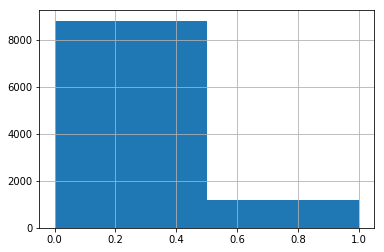

In [9]:
synthesized['type'].hist(bins=2, range=[0, 1])

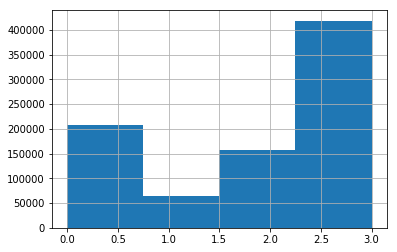

In [10]:
data['operation'].hist(bins=4, range=[0, 3])

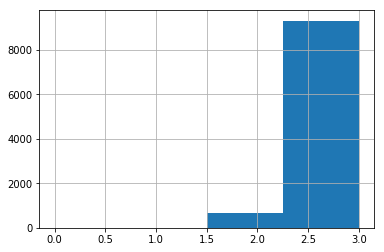

In [11]:
synthesized['operation'].hist(bins=4, range=[0, 3])

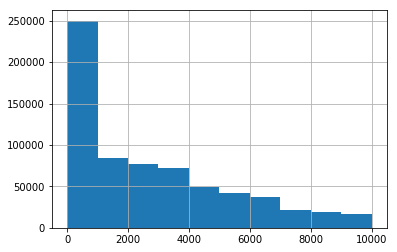

In [12]:
data['amount'].hist(bins=10, range=[0.0, 10000.0])

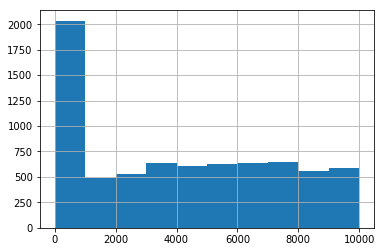

In [13]:
synthesized['amount'].hist(bins=10, range=[0.0, 10000.0])

# Tests to confirm the utility of synthetic data 

In [14]:
from synthesized.testing.testing_environment import estimate_utility
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [15]:
estimate_utility(
    df_orig=data, df_synth=synthesized,
    continuous_columns=['amount'],  categorical_columns=['type', 'operation'],
    classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor()
)

,target_column,estimator,baseline_score,synth_score,change,utility
0,amount,DecisionTreeClassifier,0.758202,0.687592,-0.070610,90.69
1,type,DecisionTreeClassifier,1.000000,0.782695,-0.217305,78.27
2,operation,DecisionTreeClassifier,0.976312,0.503975,-0.472336,51.62
